# Ultrafast image categorization *in vivo* and *in sillico*

In this notebook, we train a network to categorize images which contain or not a given class, such as *animals* or *artifacts*. We will use the [Pytorch](https://pytorch.org/) library to run the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. 

I uses transfer learning to train the DCNN, starting from a VGG16 network, taken from the `torchvision.models` library, pre-trained on the [Imagenet](http://image-net.org/) dataset which allows to perform label detection on naturals images for $K = 1000$ labels. Then re-train the whole network to perfom the same task but in a sub-set of $K = 1$ synset from the ImageNet dataset. The dataset I used here to train the networks is not multilabel (as we have the information about the occurence of only one synset on the scene), in order to train networks on independant task I choose to limit the output of the DCNN to $K = 1$ synset. 

We are going to adopt differents strategies of transfer learning:

* VGG General : Substitute the last layer of the Pytorch VGG16 network ($K = 1000$ labels) with a new layer build from a specific subset ($K = 10$ labels).
* VGG Gray : Same architecture as the VGG General network but trained with images in grayscale.
* VGG Scale : Same architecture as the VGG General network but trained with images of different size.

The first part consist of the training of the network and the last part of this notebook is dedicated to the test of the robustness of the resulted networks while appliying various geometric tranformations to the input. Finally I analyse the similarities in the performances of the networks compared with physiological data. 

This notebook was done by  [Jean-Nicolas Jérémie](https://github.com/JNJER) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/) at the Neurosciences Institute of Timone (INT). It is curated in the following [github repo](https://github.com/JNJER/2022-09_UltraFastCat).

Let's first install requirements

TODO:

* normalize the fonts

* rename experiments + backport on manuscript + make an acronym table:
 * `Gen` >> `TLC` (transfer Learning on Classification layers)
 * `Full`>> `TLA` (transfer Learning on All layers)
 * `VGG16` >> `LUT` (look up table)
 * `Custom` >> `TLDA` (Transfer Learning with Data Augmentation)
 * `Naive` >> `SLS` Supervised Learning from Scratch  ou `TLA` (transfer Learning on all layers) - or `Naive` is good :-)

* remove `HACK`s



In [1]:
# %pip install --upgrade -r requirements.txt

In [2]:
%matplotlib inline

## Initialization of the libraries/variables


Our coding strategy is to include all scripts in this notebook. This notebook contains the scripts necessary to set the variables of the definition and the training of the networks and assumes you have generated the dataset based on the [ImageNet database](https://www.image-net.org/) dedicated to our specific ecologic task. 

The set of labels of the ImageNet database is based on a large lexical database of English: [Wordnet](https://wordnet.princeton.edu/) . The nouns, verbs, adjectives, and adverbs in this database are grouped into a graphical set of cognitive synonyms (synset), each expressing a distinct concept. These synsets are linked between them by employing a small number of conceptual relations. I used the hyperonym link, for instance, a German shepherd is kind of a dog and a dog is a kind of an animal thus defining an hyperonym path. So the synset 'animal' is in the hyperonym path of the synset 'German sheperd'. Based on this relation, we selected a specific subset of labels in the ImageNet database to build our datasets.


In [3]:
data_cache = 'cached_data'
%mkdir -p {data_cache}

First of all, a `UltraFastCat/init.py` to define all our usefull variables like the new labels to learn, the number of training images or the root. Also, we importe libraries to train the networks and display the results. Then we define the `transform` functions for the datasets. 
HACK : To perform image augmentation we apply the Pytorch `AutoAugment` function to the `train` and `val` dataset. I also add a grayscale, shuffle and resize function in order to test different training strategies and test the networks on various conditions.  

In [4]:
# Importing libraries
import torch
import torch.nn.functional as nnf
import torchvision
from torchvision import datasets, transforms
# from torchvision.datasets import ImageFolder
import torch.nn as nn
torch.manual_seed(42*42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# device = torch.device('cpu')

torch.__version__, device

('1.13.1+cu117', device(type='cuda'))

In [5]:
import numpy as np
from numpy import random
import argparse
import json
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib
from matplotlib.ticker import FormatStrFormatter
fontsize = 15
font = font_manager.FontProperties(weight='normal', size=fontsize)
import seaborn as sns

# matplotlib parameters
colors = ['b', 'r', 'k', 'g', 'm', 'y']
fig_width = 15
phi = (np.sqrt(5)+1)/2 # golden ratio for the figures :-)

#to plot & display 
def pprint(message): #display function
    print('-'*len(message))
    print(message)
    print('-'*len(message))

do_savefig = False
# figpath = '../2022-12-15_Jérémie-etal-Vision_630dcf8012267a5bb40967dd/figures'
figpath = 'figures'
%mkdir -p {figpath}
opts_savefig = dict(dpi='figure', bbox_inches='tight', pad_inches=0, edgecolor=None)

/home/INT/perrinet.l/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
from nltk.corpus import wordnet as wn
import os
import time
import nltk
from time import strftime, gmtime
datetag = strftime("%Y-%m-%d", gmtime())

HOST = os.uname()[1].replace('.local', '')

# HOST, datetag = "neo-ope-de04", "2023-03-06"

# to store results
import pandas as pd

def arg_parse(args=[]):
    DEBUG = 1
    parser = argparse.ArgumentParser(description='DCNN_transfer_learning/init.py set root')
    parser.add_argument("--datasets_root", dest = 'datasets_root', help = "Directory containing datasets to perform the training",
                        default = '../data/', type = str)
    parser.add_argument("--tasks", dest = 'tasks', help =  "The different tasks we explore here",
                        default = ['animal', 'artifact', 'random'], type = list)
    parser.add_argument("--folders", dest = 'folders', help =  "Set the training, validation and testing folders relative to the root of each task",
                        default = ['test', 'val', 'train'], type = list)
    parser.add_argument("--N_images", dest = 'N_images', help ="Set the number of images per classe in the train folder",
                        default = [600//DEBUG, 400//DEBUG, 1000//DEBUG], type = list)
    parser.add_argument("--goals", dest = 'goals', help =  "Set the different categories for the tasks",
                        default = ['target', 'distractor'], type = list)
    parser.add_argument("--image_size", dest = 'image_size', help = "Set the default image_size of the input",
                    default = 256)
    parser.add_argument("--num_epochs", dest = 'num_epochs', help = "Set the number of epoch to train the models",
                    default = 25//DEBUG)
    parser.add_argument("--batch_size", dest = 'batch_size', help="Set the batch size", default = 8)
    parser.add_argument("--lr", dest = 'lr', help="Set the learning rate", default = .00005)
    parser.add_argument("--momentum", dest = 'momentum', help="Set the momentum", default = 0.99)
    parser.add_argument("--url_loader", dest = 'url_loader', help = "Set the file containing ImageNet urls",
                        default = '../DataSetMaker/Imagenet_urls_ILSVRC_2016.json', type = str)
    parser.add_argument("--model_names", dest = 'model_names', help = "Modes for the new trained networks",
                        default = ['vgg16_tlaa' ,'vgg16_tlda', 'vgg16_tla','vgg16_tlc', 'vgg16_sls'], type = list)
    return parser.parse_args(args = args)

args = arg_parse()

json_fname = os.path.join(data_cache, datetag + '_config_args.json')
print(f'Creating file {json_fname}')
with open(json_fname, 'wt') as f:
    json.dump(vars(args), f, indent=4)

Creating file cached_data/2023-03-20_config_args.json


# Training process

## Dataset using WORDNET hierarchy 

In [7]:
#DCCN training
print(f'On date {datetag}, Running benchmark on host {HOST} with device {device}')

paths = {}
for task in args.tasks :
    paths[task] = {}
    for folder in args.folders:
        paths[task][folder] = os.path.join(args.datasets_root, task, folder) # data path


#----------------Get the label for the Imagenet categorization------------------------
with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)
match = {}
for task in args.tasks :
    match[task] = []
for i_img, img_id in enumerate(Imagenet_urls_ILSVRC_2016):
    syn_= wn.synset_from_pos_and_offset('n', int(img_id.replace('n','')))
    sem_ = syn_.hypernym_paths()[0]
    for task in args.tasks[:-1]:
        for i in np.arange(len(sem_)):
            if sem_[i].lemmas()[0].name() in task :
                match[task].append(i_img)
    
match['random'] = []
random_file = '../data/random/random_choice_distractors.json'
if os.path.exists(random_file):
    print('Random mode : Using last random selection')
    with open(random_file) as f:
        class_wnids = list(json.load(f))
    for i_img, img_id in enumerate(Imagenet_urls_ILSVRC_2016):
        if img_id[:9] not in class_wnids:
            match['random'].append(i_img)
else:
    print('Missing file: something is wrong here')


# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=mean, std=std) # to normalize colors on the ImageNet dataset

image_datasets = {}
dataloaders = {}
dataset_sizes = {}

# VGG-16 datasets initialisation
def datasets_transforms(paths=paths, image_size=args.image_size, p=0, shuffle=args.image_size , num_workers=0, angle=0, batch_size=args.batch_size, **kwargs):


    if p == .5 : 
        transforms_seq = transforms.Compose([
                            # transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugmentdistractor
                            transforms.RandomHorizontalFlip(p=p),
                            transforms.RandomVerticalFlip(p=p),
                            transforms.RandomRotation(degrees=180, expand=True),
                            transforms.RandomGrayscale(p=p),
#                             https://pytorch.org/vision/master/generated/torchvision.transforms.RandomResizedCrop.html#torchvision.transforms.RandomResizedCrop
#                             scale (tuple of python:float) – Specifies the lower and upper bounds for the random area of the crop, before resizing. The scale is defined with respect to the area of the original image.
# ratio (tuple of python:float) – lower and upper bounds for the random aspect ratio of the crop, before resizing.
                            transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
                            # transforms.Resize((int(image_size), int(image_size))),              
                            transforms.ToTensor(),
                            transforms_norm ])
    elif p == 1 :
        transforms_seq = transforms.Compose([
                    transforms.Resize((int(image_size), int(image_size))),
                    transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugmentdistractor
                    transforms.ToTensor(),    # Convert the image to pyTorch Tensor data type.
                    transforms_norm ])
        
    else:
        transforms_seq = transforms.Compose([
                            transforms.Resize((int(image_size), int(image_size))),
                            transforms.ToTensor(),    # Convert the image to pyTorch Tensor data type.
                            transforms_norm ])
    
    data_transforms = {
        'train': transforms_seq,
        'val': transforms_seq,
        'test': transforms_seq}
    

    for task in args.tasks:
        image_datasets[task] = {
            folder: datasets.ImageFolder(
                paths[task][folder], 
                transform=data_transforms[folder]
            )
            for folder in args.folders
        }

        dataloaders[task] = {
            folder: torch.utils.data.DataLoader(
                image_datasets[task][folder], batch_size=batch_size,
                shuffle=False if folder == "test" else True, num_workers=num_workers
            )
            for folder in args.folders
        }

        dataset_sizes[task] = {folder: len(image_datasets[task][folder]) for folder in args.folders}

    return dataset_sizes, dataloaders, image_datasets, data_transforms

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size)

for task in args.tasks :
    pprint(f'Pre-selected tasks {task} : ')
    for folder in args.folders : print(f"Loaded {dataset_sizes[task][folder]} images under {folder}")

On date 2023-03-20, Running benchmark on host neo-ope-de04 with device cuda


FileNotFoundError: [Errno 2] No such file or directory: '../DataSetMaker/Imagenet_urls_ILSVRC_2016.json'

### Image display

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#----------------------------Display randomly picked images------------------------------------
print('\n')
pprint(f'Some sample images picked at random :')
# import imageio
import imageio.v2 as imageio
N_image_i = 4
image_plot_paths = {}
task_folder = {}
x = 0
folder = 'train'
fig, axs = plt.subplots(len(args.tasks)*len(args.goals), N_image_i, figsize=(fig_width, fig_width))
for task in args.tasks:
    for goal in args.goals:
        task_goal_folder = os.path.join(paths[task][folder], goal)
        image_plot_paths = os.listdir(task_goal_folder)
        for i_image in np.arange(N_image_i):
            ax = axs[x][i_image]
            path = os.path.join(task_goal_folder, random.choice(image_plot_paths))
            ax.imshow(imageio.imread(path))
            ax.set_xticks([])
            ax.set_yticks([])  
            if i_image%5 == 0:
                ax.set_ylabel(task + ' ' + goal, font=font)
        x +=1
fig.set_facecolor(color='white')
#-------------------------------------------------------------------



-------------------------------------
Some sample images picked at random :
-------------------------------------


ModuleNotFoundError: No module named 'imageio.v2'

## Training script

This part of the notebook focus on the training process of the network. 

The following script is a classic Training script with pyTorch. Since I only have one synset to discriminate in the scene I use `criterion = nn.BCEWithLogitsLoss()` to compute the loss during the training process. For further statistical analyses, we extract factors (like the accuracy and loss) in a `pandas`' `DataFrame` object. 

In [9]:
def train_model(model, num_epochs, dataloaders, lr=args.lr, momentum=args.momentum, batch_size=args.batch_size, log_interval=100):
    model.to(device)
    
    # https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451
    # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss
    criterion = nn.BCEWithLogitsLoss() #binary_cross_entropy_with_logits
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val']) 
    
    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        num_train = 0
        
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels.float())            
            loss.backward()
            optimizer.step()
            loss_train += loss.item() * images.size(0)
            
            preds = (outputs > 0).long()
            acc_train += (preds == labels).sum().item() # count correct predictions
            num_train += len(labels)
            
        avg_loss = loss_train / num_train
        avg_acc = acc_train / num_train
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            num_val = 0
            
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images).squeeze(1)

                loss = criterion(outputs, labels.float())
                loss_val += loss.item() * images.size(0)

                preds = (outputs > 0).long()
                acc_val += (preds == labels).sum().item() # count correct predictions
                num_val += len(labels)
                
            avg_loss_val = loss_val / num_val
            avg_acc_val = acc_val / num_val
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':avg_acc, 'avg_loss_val':avg_loss_val, 'avg_acc_val':avg_acc_val}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")
    return model, df_train

### Scan some parameters

In [10]:
scan_dicts = {'batch_size' : [8, 13, 21, 34, 55],
             'lr': args.lr * np.logspace(-1, 1, 7, base=10),
             'momentum': 1 - np.logspace(-2, -.5, 7, base=10),
            }

N_val_avg=10


for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_train_scan_{key}_{HOST}.json'
    print(f'{filename=}')
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        i_trial = 0
        measure_columns = [key, 'avg_loss_val', 'avg_acc_val', 'time']

        df_scan = pd.DataFrame([], columns=measure_columns) 
        for i_trial, value in enumerate(scan_dicts[key]):
            new_kwarg = {key: value}
            print('trial', i_trial, ' /', len(scan_dicts[key]))
            print('new_kwarg', new_kwarg)
            # Training and saving the network
            models_vgg_ = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
            # Freeze training for all layers
            # Newly created modules have requires_grad=True by default
            for param in models_vgg_.features.parameters():
                param.requires_grad = False 

            num_features = models_vgg_.classifier[-1].in_features
            features = list(models_vgg_.classifier.children())[:-1] # Remove last layer
            features.extend([nn.Linear(num_features, 1)]) # Add our layer with `n_output=1` outputs
            models_vgg_.classifier = nn.Sequential(*features) # Replace the model classifier

            since = time.time()
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, p=0, **new_kwarg)
            models_vgg_, df_train = train_model(models_vgg_, num_epochs=args.num_epochs, dataloaders=dataloaders['animal'], **new_kwarg)
            elapsed_time = time.time() - since

            print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
            print(df_train)
            df_scan.loc[i_trial] = {key:value, 'avg_loss_val':df_train.iloc[-N_val_avg:-1]['avg_loss_val'].mean(), 
                                'avg_acc_val':df_train.iloc[-N_val_avg:-1]['avg_acc_val'].mean(), 'time':elapsed_time}
            print(df_scan.loc[i_trial])
            i_trial += 1
        df_scan.to_json(filename)


filename='cached_data/2023-03-20_train_scan_batch_size_neo-ope-de04.json'
trial 0  / 5
new_kwarg {'batch_size': 8}


NameError: name 'datasets_transforms' is not defined

### Average accuracy and loss

In [11]:
subplotpars = matplotlib.figure.SubplotParams(left=0.1, right=.95, bottom=0.25, top=.975, hspace=.6)
dfs_ = {}
for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_train_scan_{key}_{HOST}.json'
    dfs_[str(key)]  = pd.read_json(filename)

fig, axs = plt.subplots(len(dfs_), 1, figsize=(fig_width, fig_width*len(dfs_)/(phi*2)), subplotpars=subplotpars)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=10)

for ax, df_train, key in zip(axs, dfs_, scan_dicts):
    ax.plot(scan_dicts[key], dfs_[df_train]["avg_acc_val"], alpha=0.5, lw=2, marker='.')
    ax.set_ylabel(f"Accuracy for {key}", size=18)
    ax.set_xlabel(f"Parameter : {key}", size=18)
    if type(scan_dicts[key][0]) == np.float64: ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_yscale("logit", one_half="1/2", use_overline=True)
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
axs[0].set_title(f'Average values of the accuracy for different parameters :', size=20);

FileNotFoundError: File cached_data/2023-03-20_train_scan_batch_size_neo-ope-de04.json does not exist

In [12]:
dfs_ = {}
for key in scan_dicts:
    filename = f'{data_cache}/{datetag}_train_scan_{key}_{HOST}.json'
    dfs_[str(key)]  = pd.read_json(filename)
fig, axs = plt.subplots(len(dfs_), 1, figsize=(fig_width, fig_width*len(dfs_)/(phi*2)), subplotpars=subplotpars)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=10)
for ax, df_train, key in zip(axs, dfs_, scan_dicts):
    ax.plot(scan_dicts[key], dfs_[df_train]["avg_loss_val"], alpha=0.5, lw=2, marker='.')
    ax.set_ylabel(f"Loss value for {key}", size=18)    
    ax.set_xlabel(f"Parameter :{key}", size=16)
    if type(scan_dicts[key][0]) == np.float64: ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
axs[0].set_title(f'Average values of the loss for different parameters :', size=20);

FileNotFoundError: File cached_data/2023-03-20_train_scan_batch_size_neo-ope-de04.json does not exist

### Learning with fine tuned parameters

In [13]:
# Training and saving the networks
models_vgg = {}
opt = {}
all_models = []   # HACK


# updating dictionary of studied models with the pretrained VGG16 and freezing all layers
model_name = 'vgg_lut'
models_vgg[model_name] = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
for param in models_vgg[model_name].features.parameters():
    param.requires_grad = False 
for param in models_vgg[model_name].classifier.parameters():
    param.requires_grad = False 

# now loading pretrained VGG16 and retrain them
for task in args.tasks :
    for model in args.model_names:
        model_name = f'{model}_{task}'

        all_models.append(model_name)
        filename = f'{data_cache}/{datetag}_{HOST}_train_{model_name}.json'
        model_filename = filename.replace('json', 'pt')
        print(filename)
        if 'sls' in model_name:
            models_vgg[model_name] = torchvision.models.vgg16(weights=None)
        else:
            models_vgg[model_name] = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        models_vgg[model_name] = models_vgg[model_name].to(device)
        if 'tla' in model_name:
            for param in models_vgg[model_name].features.parameters():
                param.requires_grad = True
        else: # model = 'tlc' or 'tlda'
            for param in models_vgg[model_name].features.parameters():
                param.requires_grad = False
        
        if 'tlaa' in model_name:
            p = 1 
        elif 'tlda' in model_name:
            p = 0.5
        else:
            p = 0
            
        num_features = models_vgg[model_name].classifier[-1].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with `n_output=1` outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier
        
        if os.path.isfile(filename):
            models_vgg[model_name].load_state_dict(torch.load(model_filename, map_location=torch.device(device)))
        else:
            print("Re-training pretrained model...", model_filename)
            print(f"Traning {model_name}, image_size={args.image_size}")
            since = time.time()
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, 
                                                                                                image_size=args.image_size, 
                                                                                                batch_size=args.batch_size, 
                                                                                                p=p)
            models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                           dataloaders=dataloaders[task], lr=args.lr, 
                                                           momentum=args.momentum)
            elapsed_time = time.time() - since
            print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
            print(f"Saving...{model_filename}")
            torch.save(models_vgg[model_name].state_dict(), model_filename)
            df_train.to_json(filename)
            print()          

cached_data/2023-03-20_neo-ope-de04_train_vgg16_tlaa_animal.json
Re-training pretrained model... cached_data/2023-03-20_neo-ope-de04_train_vgg16_tlaa_animal.pt
Traning vgg16_tlaa_animal, image_size=256


NameError: name 'datasets_transforms' is not defined

### Average accuracy and loss

In [14]:
for model_name in all_models:
    filename = f'{data_cache}/{datetag}_{HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    ax.set_xlim(-0.5, args.num_epochs)
    ax.grid(which='both')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    # ax.set_ylim(0., 1.1)
    axs.set_title(f'Average values of the loss by epoch : {filename}', fontsize=20)
    ax.get_legend().remove()
    fig.legend(bbox_to_anchor=(1.05, .5), loc='lower right', fontsize=20)

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_train_vgg16_tlaa_animal.json does not exist

In [15]:
for model_name in all_models:
    filename = f'{data_cache}/{datetag}_{HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
    ax.set_xlabel("Epoch", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    # ax.set_ylim(0.70, .998)
    ax.set_yscale("logit", one_half="1/2", use_overline=True)
    ax.grid(which='both')
    ax.set_xlim(-0.5, args.num_epochs+.5)
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    axs.set_title(f'Average values of the accuracy by epoch : {filename}', size=20)
    ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_train_vgg16_tlaa_animal.json does not exist

## Pruning

In [16]:
# Downloading the model
task = 'animal'
m = 0
input_lin_1 = 12544
pruned_depths = [28, 26, 23, 20, 18, 15, 13, 11, 8, 6, 3, 2]
all_models = ['vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']

for model_name, pruned_depth in zip(all_models, pruned_depths):
    vgg_head = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
    goal =  list(vgg_head.features.children())
    filename = f'{data_cache}/{datetag}_{HOST}_train_{model_name}.json'
    model_filename = filename.replace('json', 'pt')
    print(filename)


    models_vgg[model_name] = torchvision.models.vgg16(pretrained=True)
    conv_part = goal[:pruned_depth]
    conv_part.append(goal[-1])
    models_vgg[model_name].features = torch.nn.Sequential(*conv_part) #get the new features parameters in the model

    num_features = models_vgg[model_name].classifier[6].in_features
    features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer  
    
    if model_name in ['vgg-6', 'vgg-7', 'vgg-8']:   
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-9', 'vgg-10']:
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//2, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1
        
    elif model_name in ['vgg-11', 'vgg-12']:
        del features[0] #remove first layer
        features.insert(0, nn.Linear(input_lin_1//4, num_features)) # Add your custom input layer
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier   
        m += 1

    else : 
        features.extend([nn.Linear(num_features, 1)]) # Add our layer with n outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier     
        m += 1

    if os.path.isfile(model_filename):
        print("Loading pretrained model for..", model_name, 'from', model_filename)
        models_vgg[model_name].load_state_dict(torch.load(model_filename, map_location=torch.device(device)))
    else :
        filename = f'{data_cache}/{datetag}_{HOST}_train_{model_name}.json'
        print("Re-training pretrained model...", model_filename)
        since = time.time()
        print(f"Traning {model_name}, image_size={args.image_size}")
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=1)
        models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                    dataloaders=dataloaders[task])
        torch.save(models_vgg[model_name].state_dict(), model_filename)
        df_train.to_json(filename)
        elapsed_time = time.time() - since
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
        print()


cached_data/2023-03-20_neo-ope-de04_train_vgg-1.json


/home/INT/perrinet.l/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Re-training pretrained model... cached_data/2023-03-20_neo-ope-de04_train_vgg-1.pt
Traning vgg-1, image_size=256


NameError: name 'datasets_transforms' is not defined

# Experiments 

## Performances on natural scenes containing animals without transfer learning 

In [17]:
angles_imagenet = np.arange(-180, 181, 1)

filename = f'{data_cache}/{datetag}_{HOST}_results_rotate_imagenet.json'
print(f'{filename=}')

tasks = args.tasks
tasks.append('random')
paths['random'] = {}
for folder in args.folders:
    paths['random'][folder] = os.path.join(args.datasets_root, task, folder) # data path

if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
else:
    df_angle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var', 'effect'])
    # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=25)

    for task in tasks:
        print(task)
        for effect in ['basic', 'rot']:
            model_name = 'vgg_lut'
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                if effect == 'rot':
                    data = transforms.functional.rotate(data, angle=float(random.choice(angles_imagenet)), expand=True)
                    data = transforms.functional.resize(data, size=(args.image_size, args.image_size), antialias=True)
                data, label, = data.to(device), label.to(device)
                with torch.no_grad():
                    outputs = model(data)
                    percentage = torch.nn.functional.softmax(outputs, dim=1)
                    preds = torch.sum(percentage[:, match[task]], dim=1)
                    acc_ += torch.sum(torch.round(preds) == label.data)
            avg_acc = acc_ / dataset_sizes[task]['test']
            df_angle.loc[len(df_angle)] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':task, 'effect':effect}  
            print(model_name, float(avg_acc), task, effect)
        df_angle.to_json(filename)

filename='cached_data/2023-03-20_neo-ope-de04_results_rotate_imagenet.json'


NameError: name 'datasets_transforms' is not defined

In [18]:
filename = f'{data_cache}/{datetag}_{HOST}_results_rotate_imagenet.json'
if os.path.isfile(filename):
    df_rotate_imagenet = pd.read_json(filename)
    df_rotate_imagenet

In [19]:
if os.path.isfile(filename):

    acc_dict = df_rotate_imagenet.to_dict()
    data_rand = { 'x_abs': ['Random', 'Random + Rotation'],
            'y_val' : [acc_dict['mean_prediction'][4], acc_dict['mean_prediction'][5]]}
    data_ani = { 'x_abs': ['Animal', 'Animal + Rotation'],
            'y_val' : [acc_dict['mean_prediction'][0], acc_dict['mean_prediction'][1]]}
    data_art = { 'x_abs': ['Artifact', 'Artifact + Rotation'],
            'y_val' : [acc_dict['mean_prediction'][2], acc_dict['mean_prediction'][3]]}

    df_rand = pd.DataFrame(data_rand)
    df_ani = pd.DataFrame(data_ani)
    df_art = pd.DataFrame(data_art)

    x= ['Vgg Imagenet', 'Vgg Animal', 'Vgg Artifact']
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(fig_width, fig_width//4))
    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(x)) for i,k in enumerate(x)})
    titles = ["(A) Animal dataset", "(B) Artifact dataset" ,"(C) Random dataset" ]

    axs[2].bar(df_rand['x_abs'], df_rand['y_val'],  align='center', color=color_dict[0])
    axs[0].bar(df_ani['x_abs'], df_ani['y_val'], color=color_dict[1])
    axs[1].bar(df_art['x_abs'], df_art['y_val'], color=color_dict[2])
    axs[0].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray')
    axs[1].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray')
    axs[2].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray')
    axs[1].set_xticklabels(labels=['Artifact', 'Artifact + Rotation'], font=font)
    axs[1].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)
    axs[0].set_xticklabels(labels=['Animal', 'Animal + Rotation'], font=font)
    axs[0].set_ylabel('Accuracy', font=font)
    axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)

    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for j, ax in enumerate(axs):
            ax.set_title(titles[j], font=font)
            ax.tick_params(axis='both', labelsize=15)    
            for i, container in enumerate(ax.containers):
                    ax.bar_label(container, padding=-15, color='black', fmt='%.3f', rotation=0, label_type = 'edge', fontsize=fontsize, weight='bold')

    plt.xticks(font=font)
    plt.yticks(font=font)
    plt.tight_layout()
    if do_savefig: fig.savefig(os.path.join(figpath, 'robustness_imagenet.pdf'), **opts_savefig)

<a id="exp1"></a>
## Performances on natural scenes containing animal

Now that the networks seems ready for the comparison. This part of this notebook offers a comparison between:

- A pre-trained image recognition's networks, here VGG, trained on the [ImageNet](http://image-net.org/) dataset which allows working on naturals images for $1000$ labels, taken from the `torchvision.models` library

- And three re-trained version of the same network_ VGG16 based on a Wordnet semantic from the ImageNet database which allows working on naturals images for $1$ synsets. 

As a control I re-train networks on the artifact synset too. Another interesting analysis will be the study of the link between the performances on these two conditions. 

### Image processing and recognition for different animal label

In [20]:
filename = f'{data_cache}/{datetag}_{HOST}_results_basic.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df = pd.read_json(filename)
else:
    df = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for task in args.tasks:
        pprint(task)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg.keys():
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(data).cpu().squeeze(0)
                    if model_name == 'vgg_lut':
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0)
                        likelihood = np.asarray(percentage[match[task]]).sum()
                    else:
                        likelihood = torch.sigmoid(out).numpy()[0]
                    top_1 = 'target' if likelihood>0.50 else 'distractor'
                    elapsed_time = time.time() - tic
                df.loc[len(df)] = { 'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 
                                    'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                    'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0]}
                print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
    df.to_json(filename)


filename='cached_data/2023-03-20_neo-ope-de04_results_basic.json'


NameError: name 'datasets_transforms' is not defined

In [21]:
filename = f'{data_cache}/{datetag}_{HOST}_results_basic.json'
df = pd.read_json(filename)
df

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_basic.json does not exist

#### Computation Time

<ipython-input-22-3393b440725a>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_dict = pd.Series({k:cmap(i/len(df['model'].unique())) for i,k in enumerate(df['model'].unique())})


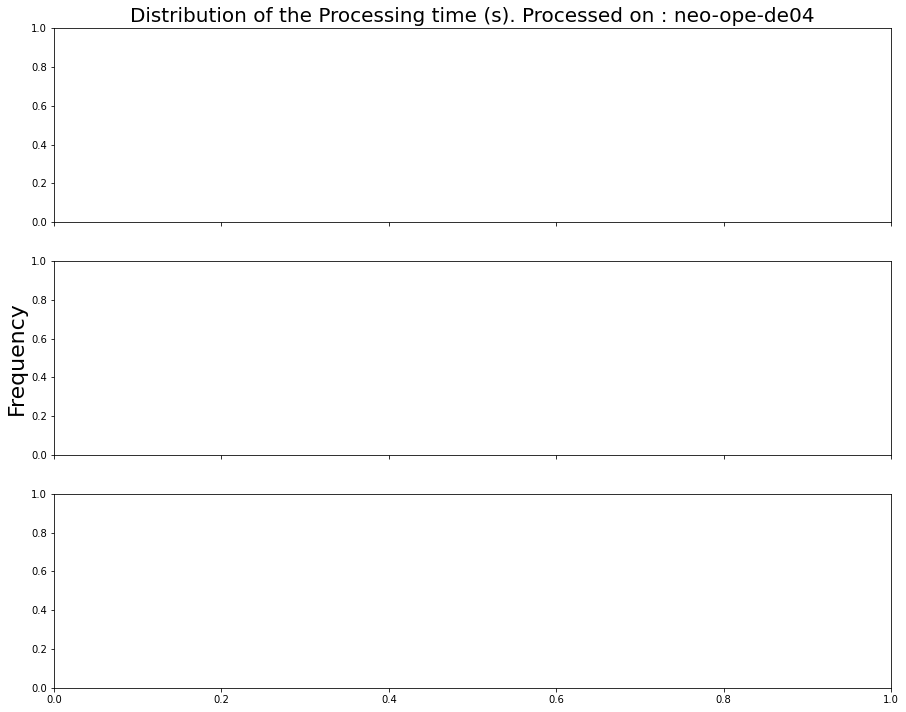

In [22]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2), sharex=True, sharey=True)
cmap = plt.cm.get_cmap('inferno')
color_dict = pd.Series({k:cmap(i/len(df['model'].unique())) for i,k in enumerate(df['model'].unique())})
for ax, color, model_name in zip(axs, color_dict, models_vgg):
    df[df['model']==model_name]['time'].plot.hist(bins=50, lw=1, label=model_name,ax=ax, color=[color_dict[model_name],], density=True)
    ax.set_xlim(df['time'].quantile(.01), df['time'].quantile(.99))
    ax.set_ylim(0, 600)
    ax.legend(bbox_to_anchor=(1.21, .35), loc='lower right', fontsize=15)
    ax.grid(which='both', axis='y')
    ax.set_xlabel('Processing time (s): ' + model_name, size=22)
    ax.set_ylabel('')
axs[0].set_title('Distribution of the Processing time (s). Processed on : ' + HOST, size=20)
axs[len(models_vgg)//2].set_ylabel('Frequency', fontsize=22);

#### Accuracy comparison for all the models

In [23]:
from sklearn.metrics import accuracy_score, f1_score

In [24]:
df_acc = pd.DataFrame({model_name: {task: accuracy_score(df[(df['model']==model_name) & (df['task']==task)]["top_1"], 
                                                             df[(df['model']==model_name) & (df['task']==task)]["goal"])
                                    for task in args.tasks} 
                       for model_name in df['model'].unique()})

ax = df_acc.T.plot.bar(rot=90, figsize=(fig_width, fig_width//4), fontsize=fontsize)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-36, color='black', fontsize=fontsize, fmt='%.2f', weight='bold', rotation=90)
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

TypeError: no numeric data to plot

KeyError: 'vgg_lut'

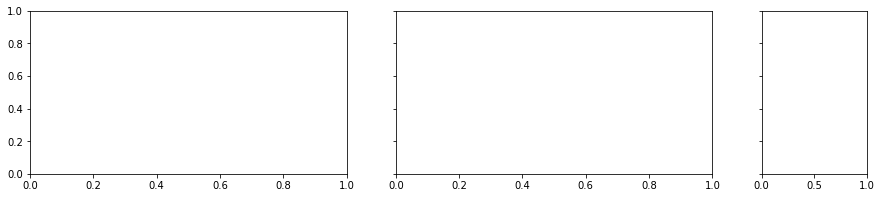

In [25]:
acc_dict = df_acc.to_dict()
model_tested = ['Vgg ImageNet', 'Vgg Animal', 'Vgg Artifact']
fig, axs = plt.subplots(1, len(model_tested), sharex=False, sharey=True, figsize=(fig_width, fig_width//4), gridspec_kw={'width_ratios': [3, 3,1]})
cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(model_tested)) for i,k in enumerate(model_tested)})
titles = ["(A) Animal dataset", "(B) Artifact dataset" , "(C) Random dataset" ]

F1_Random = .612  # HACK
data_rand = { 'x_abs': ['Vgg Random'],
        'y_val' : [ F1_Random]}
data_ani = { 'x_abs': ['Vgg LUT', 'Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict['vgg_lut']['animal'], acc_dict['vgg16_tlc_animal']['animal'], acc_dict['vgg16_tlc_artifact']['animal']]}
data_art = { 'x_abs': ['Vgg LUT', 'Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict['vgg_lut']['artifact'], acc_dict['vgg16_tlc_animal']['artifact'], acc_dict['vgg16_tlc_artifact']['artifact']]}
df_rand = pd.DataFrame(data_rand)
df_ani = pd.DataFrame(data_ani)
df_art = pd.DataFrame(data_art)

axs[2].bar(df_rand['x_abs'], df_rand['y_val'],  align='center', color= color_dict[0])
axs[0].bar(df_ani['x_abs'], df_ani['y_val'], color= color_dict[1])
axs[1].bar(df_art['x_abs'], df_art['y_val'], color= color_dict[2])
axs[2].hlines(xmin=-.5, xmax=.5, y=1/2, ls='--', ec='gray')
axs[0].hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='gray')
axs[1].hlines(xmin=-.5, xmax=2.5, y=1/2, ls='--', ec='gray')
axs[0].set_xticklabels(labels=['Vgg LUT','Vgg Animal','Vgg Artifact'], font=font)
axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)
axs[1].set_xticklabels(labels=['Vgg LUT','Vgg Animal','Vgg Artifact'], font=font)
axs[0].set_ylabel('Accuracy', font=font)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for j, ax in enumerate(axs):
    ax.set_title(titles[j], font=font)
    ax.tick_params(axis='both', labelsize=15)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, padding=-15, color='black', fmt='%.3f', rotation=0, label_type = 'edge', fontsize=fontsize, weight='bold')
        
plt.xticks(font=font)
plt.yticks(font=font)        
plt.tight_layout()
if do_savefig: fig.savefig(os.path.join(figpath, 'mean_accuracy.pdf'), **opts_savefig)

### A comparison between performances in biology and in models: Test on Serre (2007)'s dataset

 As a control, we tested the networks on the dataset of [Serre & al](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf). This dataset contains a total of $600$ targets (images containing an animal) and $600$ distractors (images not containing an animal).

In [26]:
filename = f'{data_cache}/{datetag}_{HOST}_results_serre.json'
print(f'{filename=}')

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
image_dataset_serre07 = datasets.ImageFolder('../data/Serre_2007/', transform=data_transforms['test'])
dataloaders_serre07 = torch.utils.data.DataLoader(image_dataset_serre07, batch_size=1, shuffle=False, num_workers=0)

# Output's set up
if os.path.isfile(filename):
    df_serre = pd.read_json(filename)
else:
    df_serre = pd.DataFrame([], columns=['model', 'model_task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
    for i_image, (data, label) in enumerate(dataloaders_serre07):
        data, label = data.to(device), label.to(device)
        for model_name in models_vgg.keys():
            model = models_vgg[model_name].to(device)
            with torch.no_grad():
                goal = 'target' if 'target' in image_dataset_serre07.imgs[i_image][0] else 'distractor'
                model_task = 'animal' if 'animal' in model_name else 'artifact'
                tic = time.time()
                out = model(data).squeeze(0).cpu()
                if model_name == 'vgg_lut':
                    model_task = 'Imagenet_challenge'
                    percentage = torch.nn.functional.softmax(out, dim=0)
                    likelihood = np.asarray(percentage[match['animal']]).sum()
                else:
                    likelihood = torch.sigmoid(out).numpy()[0]

                top_1 = 'target' if likelihood>0.50 else 'distractor'
                elapsed_time = time.time() - tic
            df_serre.loc[len(df_serre)] = {'model':model_name, 'model_task':model_task, 'likelihood':likelihood, 'time':elapsed_time, 
                                        'fps': 1/elapsed_time, 'goal': goal, 'i_image':i_image, 'top_1':top_1,
                                        'filename':image_dataset_serre07.imgs[i_image][0]}
            print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : animal, {goal}')
    df_serre.to_json(filename)


filename='cached_data/2023-03-20_neo-ope-de04_results_serre.json'


NameError: name 'datasets_transforms' is not defined

In [27]:
filename = f'{data_cache}/{datetag}_{HOST}_results_serre.json'
df_serre = pd.read_json(filename)
df_serre

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_serre.json does not exist

#### Image display

Here is the images with the highest likelihood of the networks :

NameError: name 'df_serre' is not defined

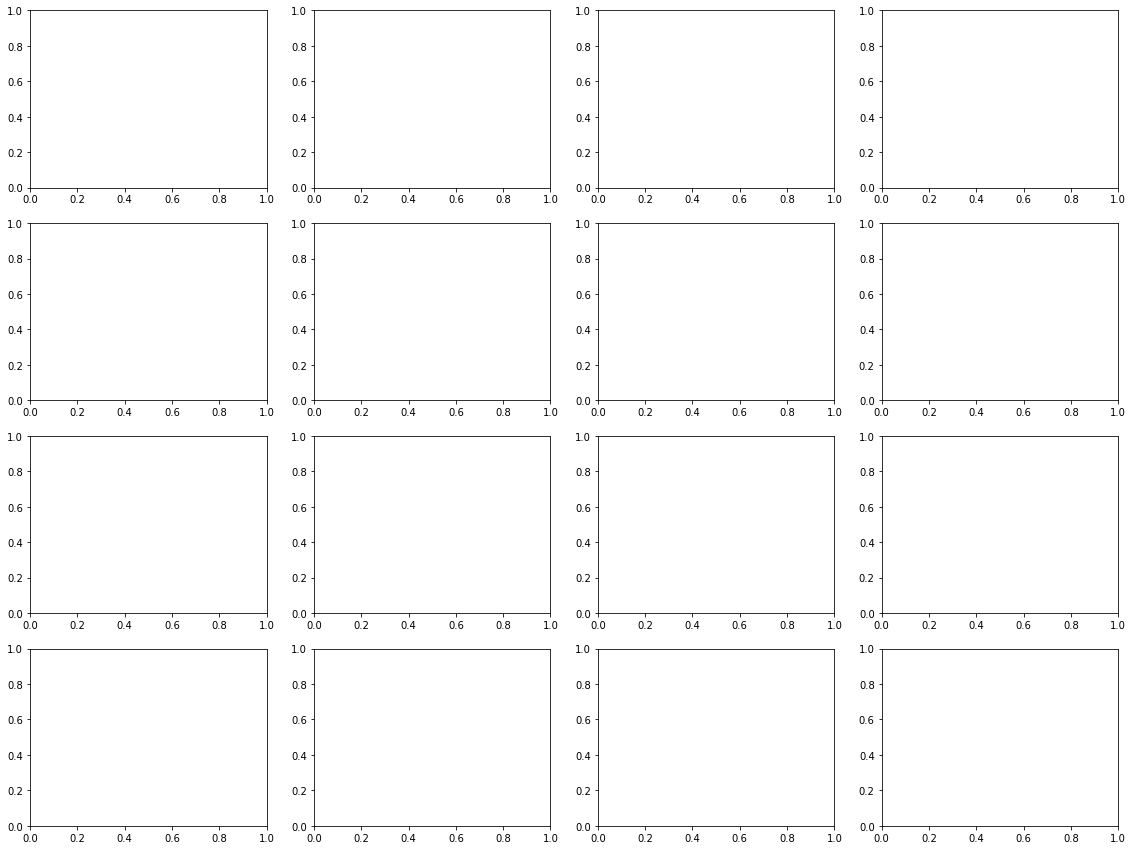

In [28]:
N_image_i = 4
N_image_j = 4
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for idx, i_image in enumerate(df_serre.sort_values(by=['likelihood'], ascending=False).head(N_image_i*N_image_j).index):
    ax = axs[idx%N_image_i][idx//N_image_i]
    img_address = image_dataset_serre07.imgs[df_serre.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_serre.loc[idx]['top_1'] == df_serre.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_serre.loc[idx]['top_1'] + ' | ' + df_serre.loc[idx]['model'], color=color)
    likelihood = df_serre.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood * 100:2.3f}%', color=color)
fig.set_facecolor(color='white')

NameError: name 'df_serre' is not defined

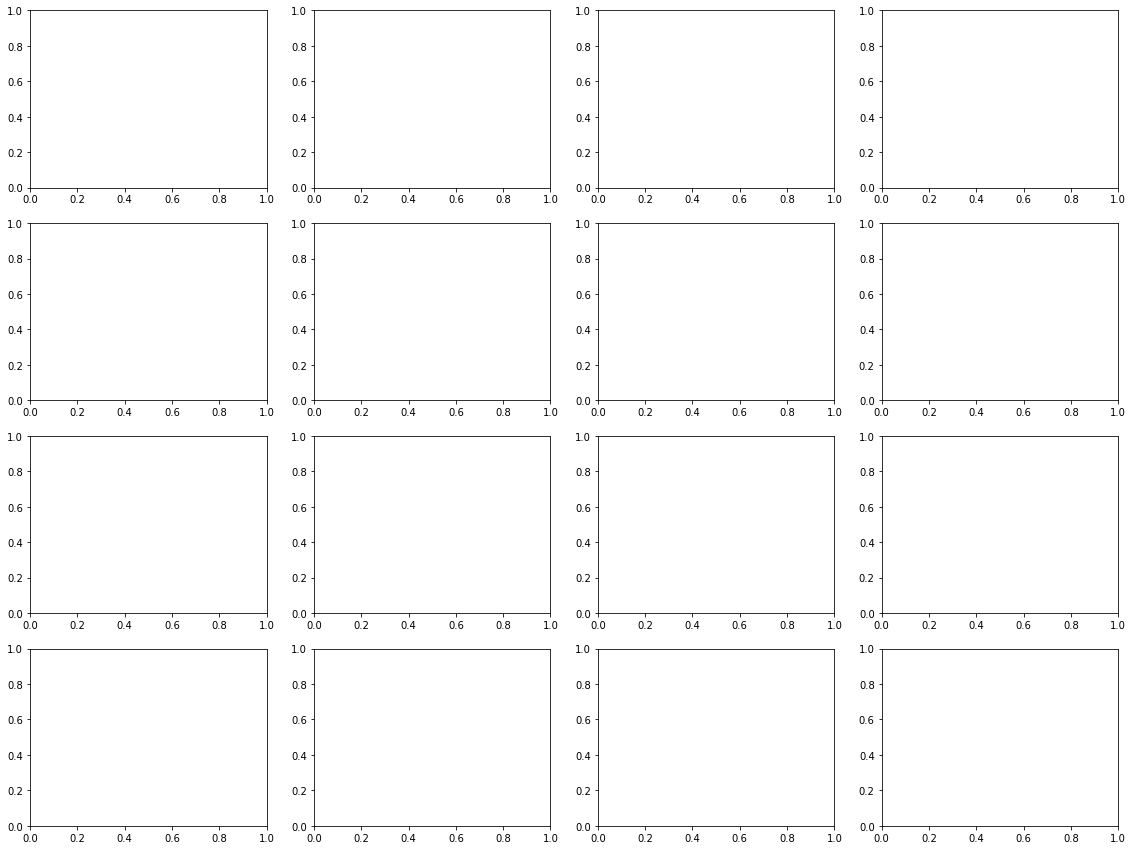

In [29]:
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width*1.3, fig_width))
for i_image, idx in enumerate(df_serre.sort_values(by=['likelihood'], ascending=True).head(N_image_i*N_image_j).index):
    ax = axs[i_image%N_image_i][i_image//N_image_i]
    img_address = image_dataset_serre07.imgs[df_serre.loc[idx]['i_image']][0]
    ax.imshow(imageio.imread(img_address))
    ax.set_xticks([])
    ax.set_yticks([])
    color = 'g' if df_serre.loc[idx]['top_1'] == df_serre.loc[idx]['goal'] else 'r'
    ax.set_xlabel(df_serre.loc[idx]['top_1'] + ' | ' + df_serre.loc[idx]['model'], color=color)
    likelihood = df_serre.loc[idx]['likelihood']
    ax.set_ylabel(f'P ={likelihood:2.3f}%', color=color)
fig.set_facecolor(color='white')

#### Accuracy

In [30]:
df_acc = pd.DataFrame({'accuracy': [accuracy_score(df_serre[df_serre['model']==model_name]["top_1"], df_serre[df_serre['model']==model_name]["goal"]) for model_name in models_vgg.keys()]}, index=models_vgg)
ax = df_acc.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=fontsize)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
ax.bar_label(ax.containers[0], padding=-24, color='black', fontsize=fontsize, weight='bold', fmt='%.3f')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.grid(which='both', axis='y')
for side in ['top', 'right'] :ax.spines[side].set_visible(False)
ax.set_title('Average accuracy top_1 : for each models - experiment 1', size=20)
ax.set_xlabel('Model', size=20);

NameError: name 'df_serre' is not defined

#### Heuristic

NameError: name 'df_serre' is not defined

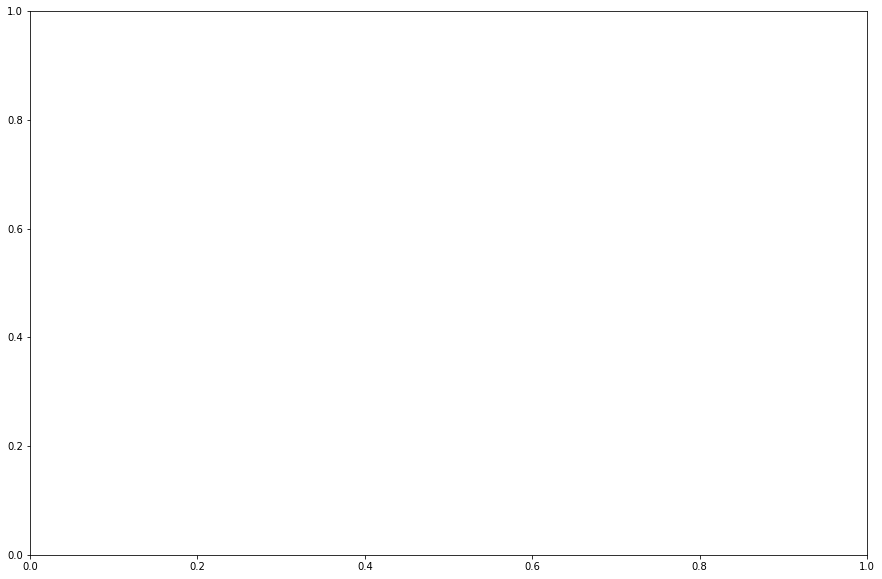

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
df_mean = pd.DataFrame([], columns=['heuristic', 'var', 'goal'])
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/len(df_serre['goal'].unique())) for i,k in enumerate(df_serre['goal'].unique())})
model_animal = []
model_artifact = []
data_animal = df_serre.loc[df_serre['model'] == 'vgg16_tlc_animal']
data_artifact = df_serre.loc[df_serre['model'] == 'vgg16_tlc_artifact']
for i_image in df_serre['i_image'].unique():
    heuristic = 1 - (1 - float(data_animal[(data_animal['i_image']==i_image)]["likelihood"])) * float(data_artifact[(data_artifact['i_image']==i_image)]["likelihood"])
    df_mean.loc[i_image] = {'heuristic':heuristic, 'var':i_image, 'goal':list(data_animal.goal)[i_image]}      
for goal in df_serre['goal'].unique():
    df_mean[(df_mean['goal']==goal)].plot.scatter(x="var", y="heuristic",  c=[color_dict[goal],],
                                                         alpha=0.5, marker='o', lw=0, ax=ax, label=goal)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Heuristic', size= 20)
ax.set_xlabel('i image', size= 20)
plt.legend(bbox_to_anchor=(1.1, .5), loc='center', fontsize=14,)
ax.set_title('Heuristic : likelihood = 1 - (1 - likelihood_animal)  * likelihood_artifact', size=20);
plt.tight_layout();

#### Comparison with psychophysical data from Serre & al 2007

In [32]:
df_serre_07 = pd.read_csv('https://raw.githubusercontent.com/laurentperrinet/PerrinetBednar15/master/database/AnimalnessIndex.csv', header=None)#, index_col=['A', 'B', 'C'])

likes_ = []
goals = []
top1_human = []
top1_model = []
data_vgg_gen = df_serre.loc[df_serre['model'] == 'vgg16_tlc_animal']
for i in range(len(df_serre_07)):
    top_1_human = 'target' if df_serre_07.iloc[i, 1]>50 else 'distractor'
    top_1_model = 'target' if df_serre_07.iloc[i, 2]>50 else 'distractor'
    top1_human.append(top_1_human)
    top1_model.append(top_1_model)
    for j in range(len(data_vgg_gen)):
        if df_serre_07.iloc[i, 0] in data_vgg_gen.iloc[j, 7] :
            goals.append(data_vgg_gen.iloc[j, 2])
            if data_vgg_gen.iloc[j, 2] == 'target':
                likes_.append(round(data_vgg_gen.iloc[j, 3]))
            else:
                likes_.append(100-round(data_vgg_gen.iloc[j, 3] * 100))
                df_serre_07.iloc[i, 1] = 100 - df_serre_07.iloc[i, 1]
                df_serre_07.iloc[i, 2] = 100 - df_serre_07.iloc[i, 2]

df_serre_07.insert( 3, 'human', top1_human)
df_serre_07.insert( 4, 'model', top1_model)
df_serre_07.insert(5, 'TLC', likes_)
df_serre_07.insert(6, 'goals', goals)
df_serre_07

NameError: name 'df_serre' is not defined

KeyError: 'TLC'

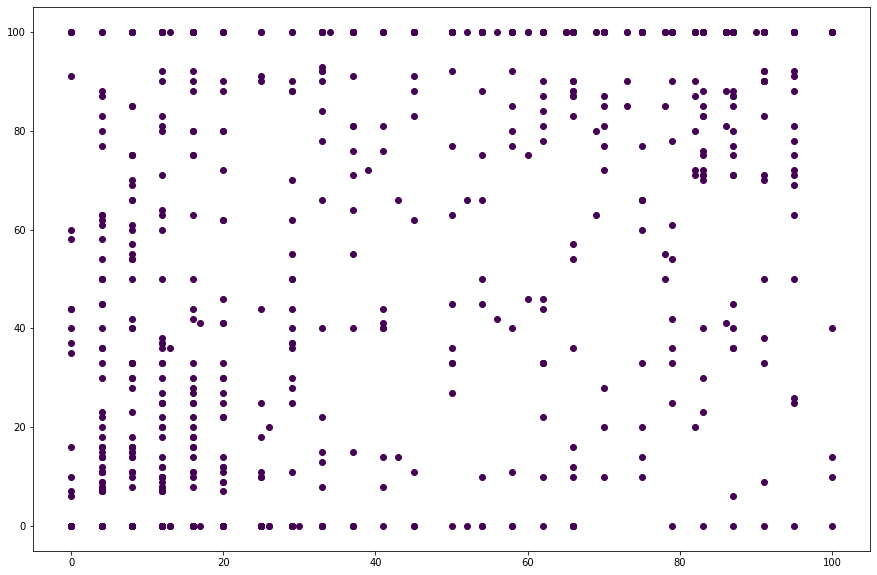

In [33]:
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap(i/3) for i,k in enumerate(range(3))})
fig, ax = plt.subplots(figsize=(15, 10))

names_ = ['Model Serre_07', 'Human', 'Vgg_tlc_Animal']
plt.scatter(df_serre_07[1], df_serre_07[2], label='Model Serre_07', color=color_dict[0])
plt.scatter(df_serre_07[1], df_serre_07['TLC'], label='Vgg_tlc_Animal', color=color_dict[2])

ax.tick_params(axis='y', labelsize=14)
plt.xticks(font=font)
plt.yticks(font=font)
plt.legend(bbox_to_anchor=(1.17, .5), loc='center', fontsize=20)
ax.set_ylabel("""Model's likelihood""", font=font)
ax.set_xlabel("""Human's Accuracy""", font=font)
plt.tight_layout()
# if do_savefig: fig.savefig(os.path.join(figpath, 'physio_comparison.pdf'), **opts_savefig)

https://github.com/laurentperrinet/PerrinetBednar15/blob/master/notebooks/5%20notebook_figure_animalness.ipynb

Here is the images with the lowest likelihood of the networks :

#### Conclusion

The networks obtain an accuracy on the 'animal' synset similar to those found in the model and neurophysiological data of [Serre & al (2007)](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf) (about 83\%). Yet, the bias found in is also present in the dataset used by [Serre & al (2007)](http://vision.stanford.edu/teaching/cs131_fall1415/lectures/Serre2007.pdf).  when we compare the performances of humans on this dataset with the performances achieved by the network on an image-by-image basis we found in  [experiment 1](#exp1). However, we also found a high correspondence (about 84%) between the correct predictions of human and our model. Indeed for some images the networks failed the categorization but the human succeeds and vice versa. For some images both the network and human succeed or failed to categorize an animal. These exemples could be the reflection of the specific features on which humans or our models rely to perform their categorization.

<a id="exp2"></a>
## Robustness of the categorization with different geometric transformations


### Image processing and recognition for differents flip transformations

In [34]:
flips = {}
flips['Horizontal'] = transforms.RandomHorizontalFlip(p=1) 
flips['Vertical'] = transforms.RandomVerticalFlip(p=1)

filename = f'{data_cache}/{datetag}_{HOST}_results_flip.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df = pd.read_json(filename)
else:
    df_flip = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'flip'])   
    # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for flip in flips:
        pprint(flip)
        for task in args.tasks:
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = flips[flip](data)
                data, label, = data.to(device), label.to(device)
                for model_name in models_vgg.keys():
                    model = models_vgg[model_name].to(device)
                    with torch.no_grad():
                        goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                        tic = time.time()
                        out = model(data).squeeze(0).cpu()
                        model_task = 'animal' if 'animal' in model_name else 'artifact'
                        if model_name == 'vgg_lut':
                            model_task = 'Imagenet_challenge'
                            percentage = torch.nn.functional.softmax(out, dim=0)
                            likelihood = np.asarray(percentage[match[task]]).sum()
                        else:
                            likelihood = torch.sigmoid(out).numpy()[0]
                        elapsed_time = time.time() - tic
                        top_1 = 'target' if likelihood>0.50 else 'distractor'
                    df_flip.loc[len(df_flip)] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal,        
                                            'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                            'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'flip':flip}
                    print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')


    df_flip.to_json(filename)


filename='cached_data/2023-03-20_neo-ope-de04_results_flip.json'


NameError: name 'datasets_transforms' is not defined

In [35]:
filename = f'{data_cache}/{datetag}_{HOST}_results_flip.json'
df_flip = pd.read_json(filename)

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_flip.json does not exist

#### Computation Time

ValueError: min() arg is an empty sequence

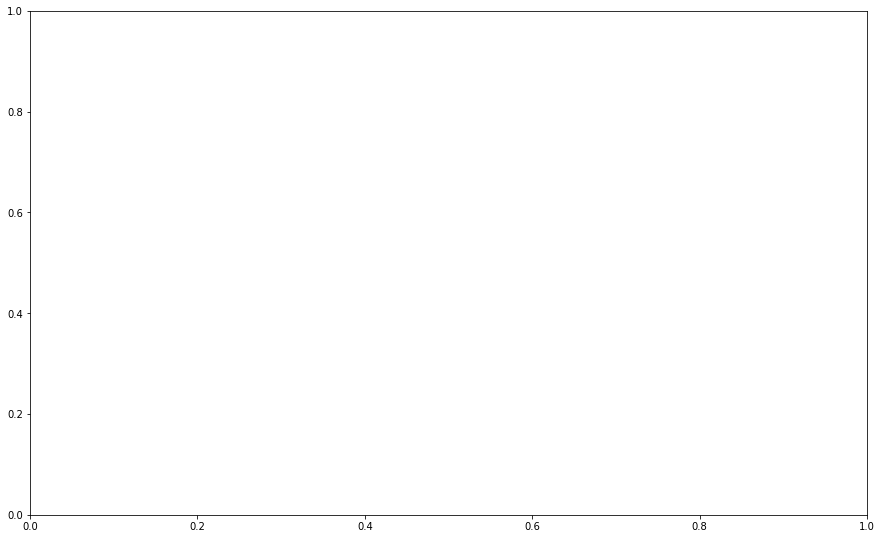

In [36]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="flip", y="time", data=df_flip, inner="quartile", hue='model')
    axs.set_title('Processing time (s) for each network at different image size. Processed on : ' + HOST, size=20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Image size', size=18)
    axs.set_yscale('log')
    axs.grid(which='both', axis='y')
    for side in ['top', 'right'] :axs.spines[side].set_visible(False)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

#### Accuracy comparison for all the models

/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dt

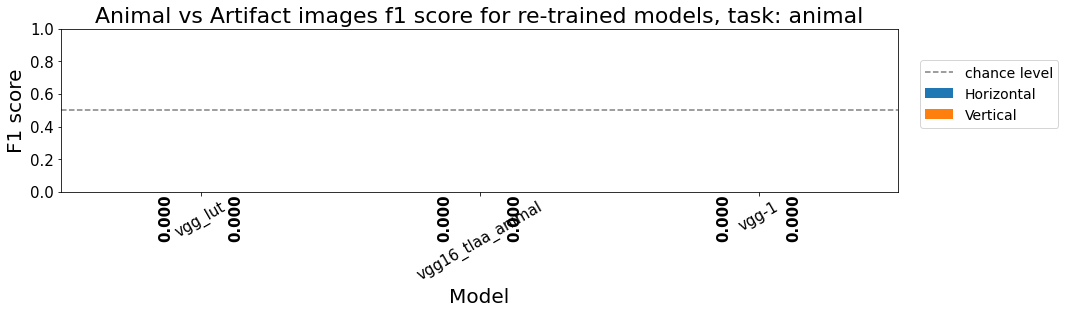

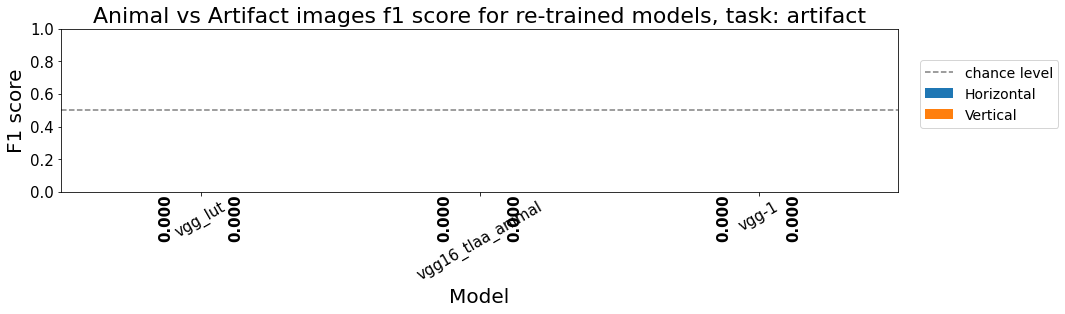

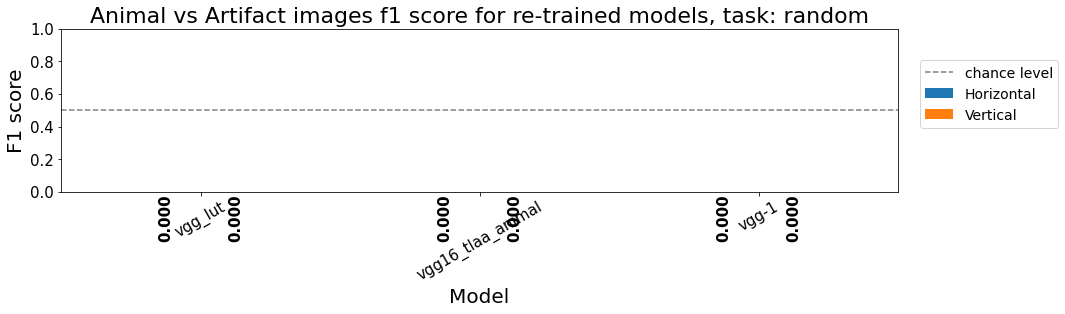

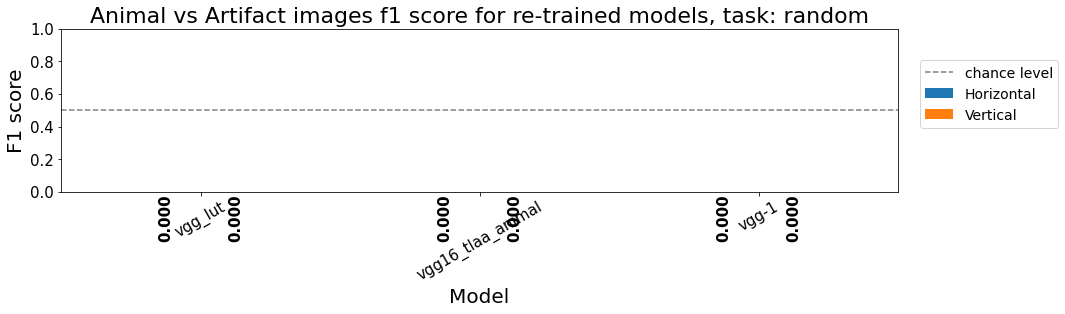

In [37]:
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {flip: accuracy_score(df_flip[(df_flip['model']==model_name) & (df_flip['task']==task) & (df_flip['flip']==flip) ]["top_1"], 
                                                                   df_flip[(df_flip['model']==model_name) & (df_flip['task']==task) & (df_flip['flip']==flip)]["goal"])
                                        for flip in flips} 
                           for model_name in models_vgg.keys()})

    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=fontsize)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/2, ls='--', ec='gray', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=fontsize, weight='bold', fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=14)
    ax.set_title(f'Animal vs Artifact images f1 score for re-trained models, task: {task}', size=22)
    ax.set_ylabel('F1 score', size=20)
    ax.set_xlabel('Model', size=20);

#### Conclusion

We tested the Vgg TLC network on the ImageNet dataset with either a vertical or horizontal reflection applied on the input. The networks keeps a good mean accuracy on the flipped dataset (about 95%).


### Image processing and recognition on grayscale images :

Again, same likelihood indicators but now with a grayscale transformation.

In [38]:
filename = f'{data_cache}/{datetag}_{HOST}_results_grayscale.json'
print(f'{filename=}')

transforms_gray = transforms.RandomGrayscale(p=1)

if os.path.isfile(filename):
    df_gray = pd.read_json(filename)
else:
    df_gray = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for task in args.tasks:
        pprint(task)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg.keys():
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    tic = time.time()
                    out = model(transforms_gray(data)).squeeze(0).cpu()
                    if model_name == 'vgg_lut':
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0)
                        likelihood = np.asarray(percentage[match[task]]).sum()
                    else:
                        likelihood = torch.sigmoid(out).numpy()[0]
                    top_1 = 'target' if likelihood>0.50 else 'distractor'
                    elapsed_time = time.time() - tic
                df_gray.loc[len(df_gray)] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                        'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0]}
                print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
    df_gray.to_json(filename)


filename='cached_data/2023-03-20_neo-ope-de04_results_grayscale.json'


NameError: name 'datasets_transforms' is not defined

In [39]:
filename = f'{data_cache}/{datetag}_{HOST}_results_grayscale.json'
df_gray = pd.read_json(filename)

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_grayscale.json does not exist

#### Computation time

TypeError: no numeric data to plot

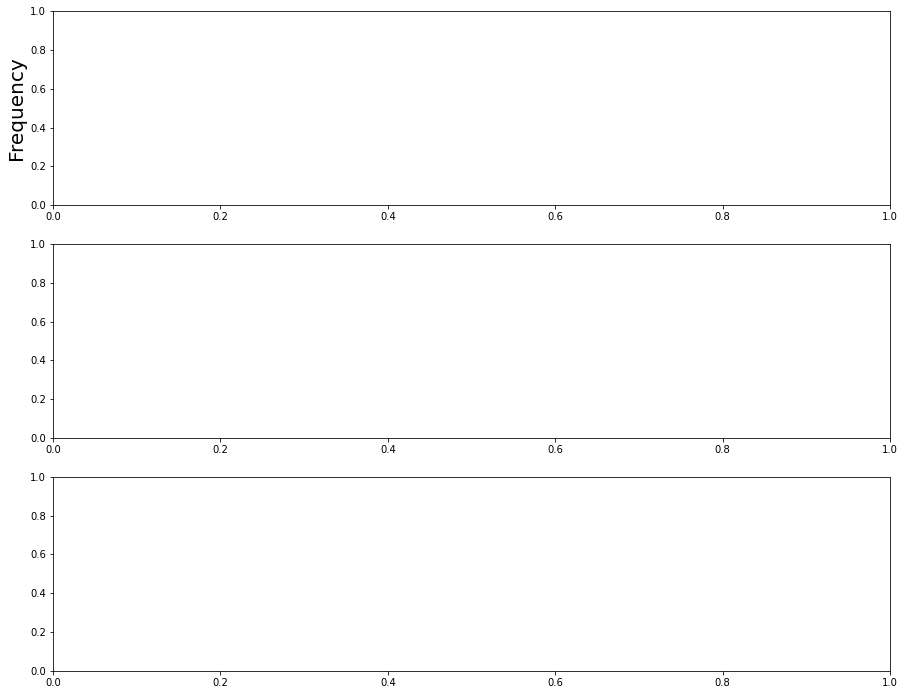

In [40]:
fig, axs = plt.subplots(len(models_vgg), 1, figsize=(fig_width, fig_width*phi/2))
for color, df_, label, legend in zip(['gray', 'red'], [df_gray, df], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models_vgg):
        ax.set_ylabel('Frequency', fontsize=20) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper right', fontsize=20)
        ax.set_xlim(df_gray['time'].quantile(.01), df_gray['time'].quantile(.99))
        ax.legend(bbox_to_anchor=(1.18, .35), loc='lower right')
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + HOST, size=20);

#### Accuracy

/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dt

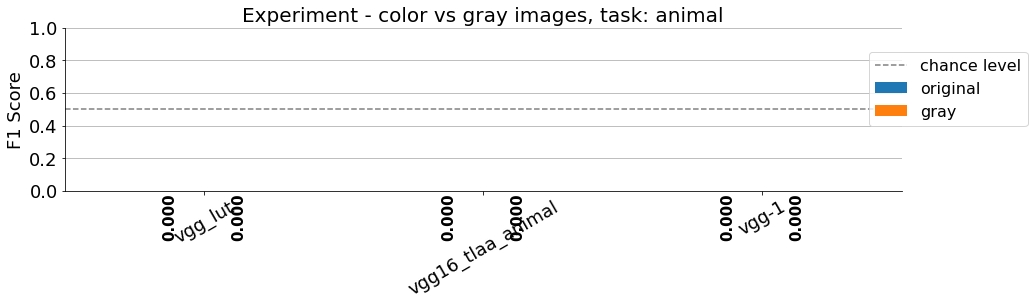

/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dt

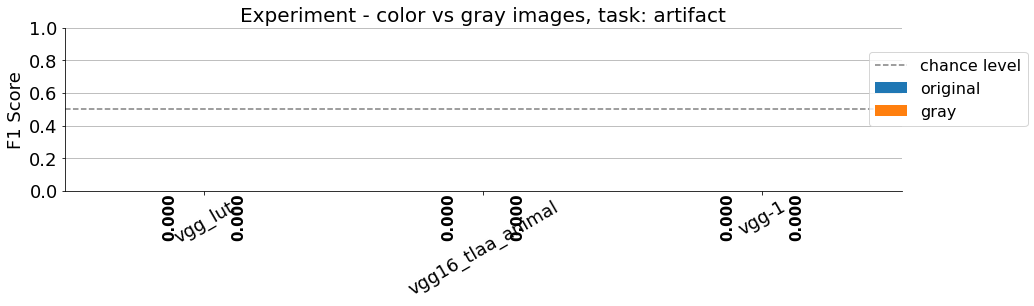

/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dt

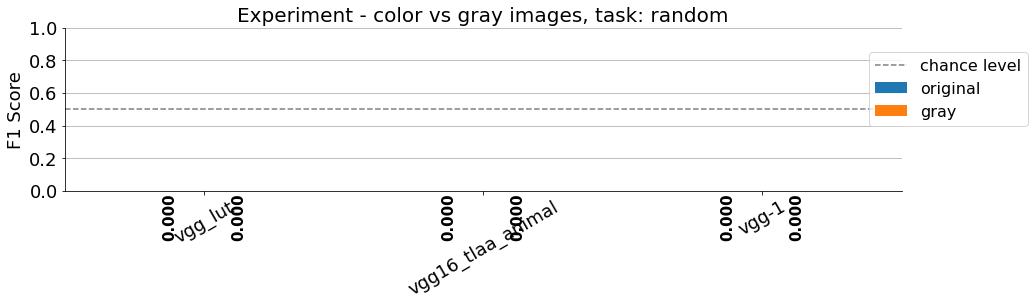

/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/INT/perrinet.l/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dt

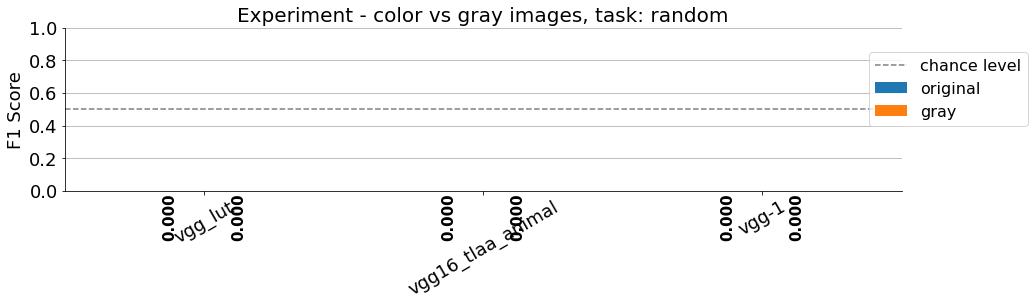

In [41]:
for task in args.tasks:
    df_acc = pd.DataFrame({model_name: {label: accuracy_score(df_[(df_['model']==model_name) & (df_['task']==task)]["top_1"], 
                                                                   df_[(df_['model']==model_name) & (df_['task']==task)]["goal"])
                                        for label, df_ in zip(['original', 'gray'], [df, df_gray])} 
                           for model_name in models_vgg.keys()})

    ax = df_acc.T.plot.bar(rot=30, figsize=(fig_width, fig_width//4), fontsize=18)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='gray', label='chance level')
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
    for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=fontsize, weight='bold', fmt='%.3f', rotation=90)
    plt.legend(bbox_to_anchor=(1.16, .35), loc='lower right', fontsize=16)
    ax.grid(which='both', axis='y')
    for side in ['top', 'right'] :ax.spines[side].set_visible(False)
    ax.set_title(f'Experiment - color vs gray images, task: {task}', size=20)
    ax.set_ylabel('F1 Score', size=18)
    plt.show();

#### Conclusion

We tested the networks on the ImageNet dataset with a grayscale filter applied on the input. The networks keeps a good mean accuracy on the grayscale dataset (about 94%). Note that the Vgg Gray networks achieves the task with a gray scale applied with a sightly better mean accuracy ([experiment 4](#exp4)) but not on the regular 'test' dataset ([experiment 1](#exp1)).

###  Image processing and recognition on rotated images :

In addition we tested all networks on our IMAGENET dataset while rotating the image around the center by -180° to +180°.

In [42]:
angles = np.arange(-180, 181, 15)
filename = f'{data_cache}/{datetag}_{HOST}_results_rotate.json'
print(f'{filename=}')
   
if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
else:
    df_angle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=64)
    # image preprocessing
    for task in args.tasks:
        print(task)
        for angle in angles:
            print(f'Rotation by {angle=}°')
            for model_name in models_vgg.keys():
                model = models_vgg[model_name].to(device)
                acc_= 0
                for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                    data, label, = data.to(device), label.to(device)
                    data = transforms.functional.rotate(data, angle=float(angle), expand=True)
                    data = transforms.functional.resize(data, size=(args.image_size, args.image_size), antialias=True)
                    with torch.no_grad():
                        outputs = model(data)
                        if model_name == 'vgg_lut':
                            percentage = torch.nn.functional.softmax(outputs, dim=1)
                            preds = torch.sum(percentage[:, match[task]], dim=1)
                            acc_ += torch.sum(torch.round(preds) == label.data)
                        else:
                            preds = torch.round(torch.sigmoid(outputs[:,0].data))
                            acc_ += torch.sum(preds == label.data)
                avg_acc = acc_ / dataset_sizes[task]['test']
                df_angle.loc[len(df_angle)] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':angle}  
                print(model_name, float(avg_acc), angle)
    df_angle.to_json(filename)


filename='cached_data/2023-03-20_neo-ope-de04_results_rotate.json'


NameError: name 'datasets_transforms' is not defined

In [43]:
filename = f'{data_cache}/{datetag}_{HOST}_results_rotate.json'

if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
    df_angle_animal = df_angle[:len(df_angle)//2]
    df_angle_artifact = df_angle[len(df_angle)//2:]

In [44]:
if os.path.isfile(filename):
    fig, ax = plt.subplots(figsize=(10, 5))
    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(df_angle_artifact['model'].unique())) for i,k in enumerate(df_angle_artifact['model'].unique())})

    for model_name in df_angle['model'].unique():     
        df_angle_artifact[(df_angle_artifact['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                            marker='o', lw=0, label=model_name, ax=ax)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0.5, 1)
    ax.set_xlim(-185, 185)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_ylabel('Mean Accuracy', font=font)
    ax.set_xlabel('Rotation (°)', font=font)

    plt.legend(bbox_to_anchor=(1.28, .5), loc='center', fontsize=10, prop=font)
    plt.xticks(font=font)
    plt.yticks(font=font);

In [45]:
if os.path.isfile(filename):

    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(df_angle_animal['model'].unique())) for i,k in enumerate(df_angle_animal['model'].unique())})

    for model_name in df_angle['model'].unique():     
        df_angle_animal[(df_angle_animal['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                            marker='o', lw=0, label=model_name, ax=ax)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0.5, 1)
    ax.set_xlim(-185, 185)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_ylabel('Mean Accuracy', font=font)
    ax.set_xlabel('Rotation (°)', font=font)
    plt.legend(bbox_to_anchor=(1.28, .5), loc='center', fontsize=10, prop=font)
    plt.xticks(font=font)
    plt.yticks(font=font);

In [46]:
color_dict

0    (0.267004, 0.004874, 0.329415, 1.0)
1    (0.190631, 0.407061, 0.556089, 1.0)
2     (0.20803, 0.718701, 0.472873, 1.0)
dtype: object

In [47]:
if os.path.isfile(filename):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    grphe1 = ['vgg_lut', 'vgg16_tlc_animal']
    grphe2 = ['vgg16_tlc_animal', 'vgg16_tlda_animal']
    all_ = ['temp', 'vgg_lut', 'temp', 'vgg16_tlc_animal', 'temp', 'vgg16_tlda_animal']
    all_ = ['temp', 'vgg_lut', 'temp', 'vgg16_tlc_animal', 'temp', 'vgg16_tlda_animal']

    cmap = plt.cm.get_cmap('viridis')
    color_dict = pd.Series({k:cmap(i/len(all_)) for i,k in enumerate(all_)})
    label_dict = {'vgg_lut':'VGG LUT', 'vgg16_tlc_animal':'VGG TLC', 'vgg16_tlda_animal':'VGG Augment'}

    graphes = [grphe1, grphe2]
    for ax, graphe in zip(axs, graphes):
        for model_name in graphe:
            df_angle_model = (df_angle_animal['model']==model_name)
            # df_angle_animal[df_angle_model].plot.scatter(x="var", y="mean_prediction", 
            #                                              c=[color_dict[model_name]],
            #                                              marker='o', label=label_dict[model_name], lw=2., ax=ax)
            df_angle_animal[df_angle_model].plot(x="var", y="mean_prediction", 
                                                         color=[color_dict[model_name]],
                                                         marker='o', label=label_dict[model_name], lw=2., ax=ax)
                                                                
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(0.5, 1)
        ax.set_xlim(-185, 185)
        ax.set_xticks([-180, -90, 0, 90, 180])
        ax.set_ylabel('Accuracy', font=font)
        ax.set_xlabel('Rotation (°)', font=font)
        ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([.5, .75, 1]))
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_font(font)
        # ax.get_legend().remove()
        # ax_dict['top'].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
        #               ncol=2, mode="expand", borderaxespad=0.)
        ax.legend(loc='lower left', fontsize=18, edgecolor='none')

    if do_savefig: fig.savefig(os.path.join(figpath, 'full_rot.pdf'), **opts_savefig)

#### Conclusion

The image size or a gray filter during training does not seem to impact the robustness to rotation as all three networks follow the same accuracy level for the categorization. Furthermore,
these three networks maintain a good accuracy during the process (VGG TLC 90.272 +/- 2.05, VGG GRAY 89.464 +/-2.72, VGG SCALE 89.222: +/- 2.722) (see Figure 5). As the networks seems robust to relection [experiment 2](#exp2), to the resolution [experiment 3](#exp3) (in a short range centered in the training resolution) and to grayscale [experiment 4](#exp4), the robustness of the categorization to different image transformations by the models are similar to that reported in psychophysics. 

## What features are necessary to achieve the task? 

<a id="exp1"></a>
### Performances on natural scenes containing animal with prunned networks

In [48]:
filename = f'{data_cache}/{datetag}_{HOST}_results_1_del_lay.json'
print(f'{filename=}')
task = 'animal'

if os.path.isfile(filename):
    df_del_lay = pd.read_json(filename)
else:
    df_del_lay = pd.DataFrame([], columns=['model', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=1)
    for i_image, (data, label) in enumerate(dataloaders[task]['test']):
        data, label = data.to(device), label.to(device)
        for model_name in models_vgg.keys():
            model = models_vgg[model_name].to(device)
            with torch.no_grad():
                goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                tic = time.time()
                out = model(data).squeeze(0).cpu()
                if model_name == 'vgg_lut':
                    model_task = 'Imagenet_challenge'
                    percentage = torch.nn.functional.softmax(out, dim=0)
                    likelihood = np.asarray(percentage[match[task]]).sum()
                else:
                    likelihood = torch.sigmoid(out).numpy()[0]
                top_1 = 'target' if likelihood>0.50 else 'distractor'
                elapsed_time = time.time() - tic
            df_del_lay.loc[len(df_del_lay)] = {'model':model_name, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                    'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0]}
            print(f'The {model_name} model categorize an animal with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth= {task}, {goal}')
    df_del_lay.to_json(filename)
df_del_lay

filename='cached_data/2023-03-20_neo-ope-de04_results_1_del_lay.json'


NameError: name 'datasets_transforms' is not defined

In [49]:
df_del_lay

,model,goal,likelihood,fps,time,i_image,filename,top_1


In [50]:
results = []
cmap = plt.cm.get_cmap('viridis')
models = df_del_lay['model'].unique()
N_model = len(models)

In [51]:
models

array([], dtype=object)

In [52]:
models[2:]

array([], dtype=object)

In [53]:
# models[2:] = models[1:-1] # HACK
# models[1] = 'vgg16_tlc'
# models[0] = 'vgg_lut'
models

array([], dtype=object)

In [54]:
df_acc = pd.DataFrame({model_name: {'accuracy': accuracy_score(df_del_lay[(df_del_lay['model']==model_name)]["top_1"], 
                                                         df_del_lay[(df_del_lay['model']==model_name)]["goal"])
                                    } 
                       for model_name in models})

ax = df_acc.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=fontsize)

TypeError: no numeric data to plot

<ipython-input-55-b6098d8ed658>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_acc = pd.Series({model_name: accuracy_score(df_del_lay[(df_del_lay['model']==model_name)]["top_1"],


IndexError: index 0 is out of bounds for axis 0 with size 0

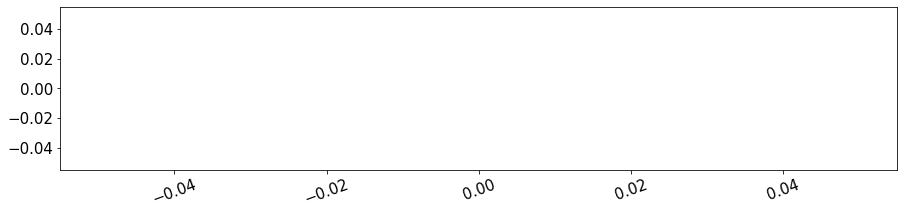

In [55]:
df_acc = pd.Series({model_name: accuracy_score(df_del_lay[(df_del_lay['model']==model_name)]["top_1"], 
                                                         df_del_lay[(df_del_lay['model']==model_name)]["goal"])
                       for model_name in models})

ax = df_acc.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=fontsize)

In [56]:
df_acc.rename({'vgg16_tlc': 'VGG TLC', 'vgg_lut': 'VGG LUT'}, inplace=True)

In [57]:
df_acc.index

Index([], dtype='object')

In [58]:
color_dict

0    (0.267004, 0.004874, 0.329415, 1.0)
1    (0.190631, 0.407061, 0.556089, 1.0)
2     (0.20803, 0.718701, 0.472873, 1.0)
dtype: object

ValueError: Invalid color argument: []

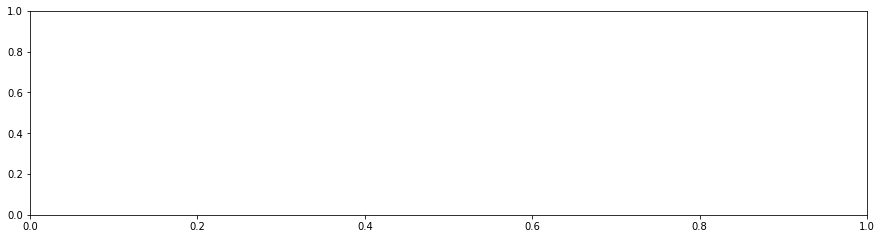

In [59]:
color_dict = {model_name: cmap(i/N_model + .25) for i, model_name in enumerate(models)}
colors = [cmap(1-.9*i_color/N_model) for i_color in range(N_model)]
fig, ax = plt.subplots(figsize=(fig_width, fig_width/4))

ax = df_acc.plot(kind='bar',    # Plot a bar chart
                 rot=20, fontsize=fontsize,
                 legend=False,    # Turn the Legend off
                 width=0.75,      # Set bar width as 75% of space available
                 ax=ax,
                 color=colors)

ax.hlines(xmin=-.5, xmax=N_model-.5, y=1/2, ls='--', ec='gray')
ax.set_ylabel('Accuracy', font=font)

for container in ax.containers: 
    # ax.bar_label(container, padding=-50, fmt='%.3f', rotation=90, color='white', fontsize=fontsize, weight='bold')
    ax.bar_label(container, padding=-50, fmt='%.3f', rotation=90, color='black', fontsize=fontsize, weight='bold')

if do_savefig: fig.savefig(os.path.join(figpath, 'pruning_accuracy.pdf'), **opts_savefig)

<a id="exp1"></a>
### Image processing and recognition for differents labels with rotation with prunned networks

In [60]:
# %rm {filename}

In [61]:
filename = f'{data_cache}/{datetag}_{HOST}_results_rotate_pruned.json'
print(f'{filename=}')

if os.path.isfile(filename):
    df_angle = pd.read_json(filename)
else:
    df_angle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(paths=paths, image_size=args.image_size, batch_size=batch_size)
    # image preprocessing
    #for task in args.tasks:
    task = 'animal'
    for angle in angles:
        print(f'Rotation by {angle=}°')
        for model_name in models_vgg.keys():
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders[task]['test']):
                data = transforms.functional.rotate(data, angle=float(angle), expand = True)
                data, label, = data.to(device), label.to(device)
                with torch.no_grad():
                    outputs = model(data)
                    if model_name == 'vgg_lut':
                        percentage = torch.nn.functional.softmax(outputs, dim=1)
                        preds = torch.sum(percentage[:,match[task]], dim=1)
                        acc_ += torch.sum(torch.round(preds) == label.data)
                    else:
                        preds = torch.round(torch.sigmoid(outputs[:,0].data))
                        acc_ += torch.sum(preds == label.data)
            avg_acc = acc_ / dataset_sizes[task]['test']
            df_angle.loc[len(df_angle)] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':angle}  
            print(model_name, float(avg_acc), angle)
            #print(f'The {model_name} model categorize {model_task} with {likelihood*100:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
            # torch.cuda.empty_cache()
    df_angle.to_json(filename)

filename='cached_data/2023-03-20_neo-ope-de04_results_rotate_pruned.json'


NameError: name 'datasets_transforms' is not defined

In [62]:
df_angle.rename({'vgg16_tlc': 'VGG TLC', 'vgg_lut': 'VGG LUT'}, axis=1, inplace=True)
df_angle.index

Index([], dtype='object')

In [63]:

filename = f'{data_cache}/{datetag}_{HOST}_results_rotate_pruned.json'
df_angle = pd.read_json(filename)
df_angle

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_rotate_pruned.json does not exist

In [64]:
models, model_name

(array([], dtype=object), 'vgg_lut')

In [65]:
model_names = {model:model for model in models}
model_names['vgg16_tlc'] = 'VGG TLC'
model_names['vgg_lut'] = 'VGG LUT'
model_names

{'vgg16_tlc': 'VGG TLC', 'vgg_lut': 'VGG LUT'}

<ipython-input-66-5b4c91daa8f3>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


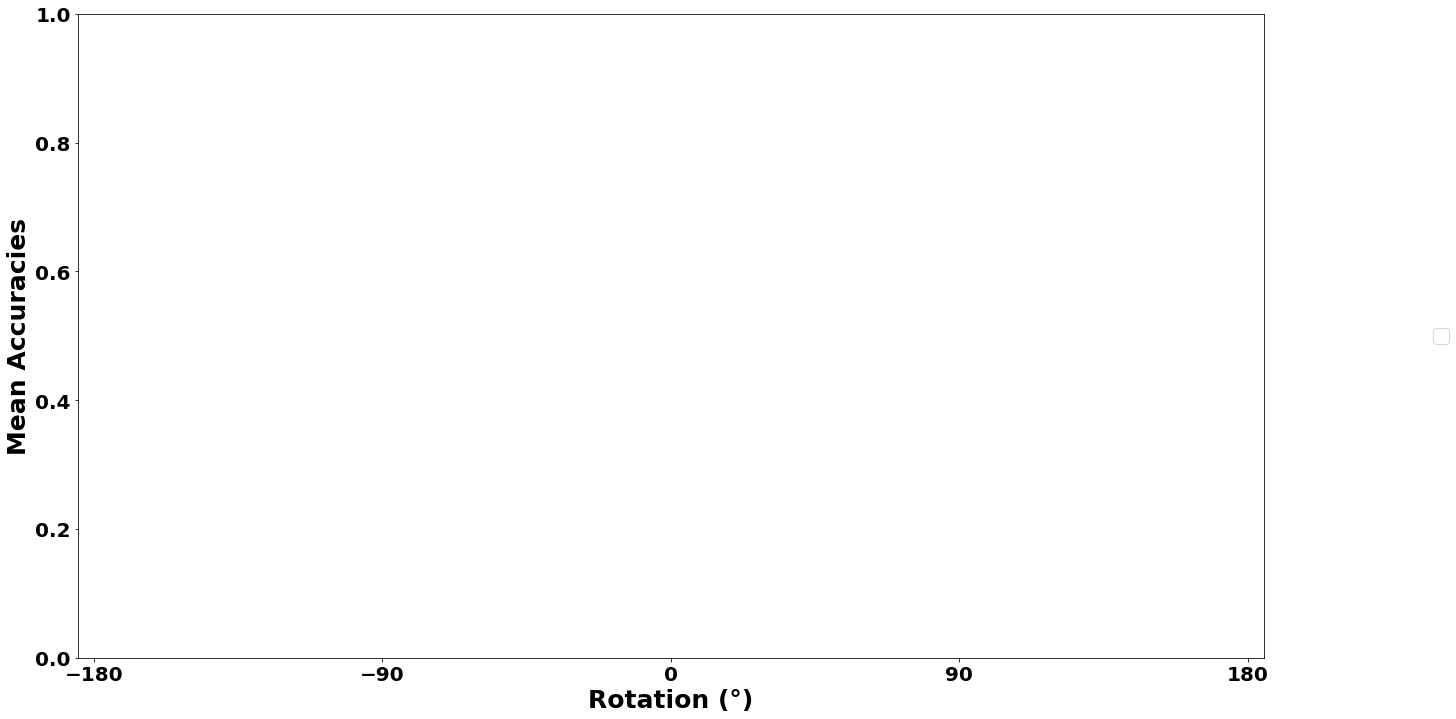

In [66]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import statistics
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
angles = np.arange(-180, -55, 1)
cmap = plt.cm.get_cmap('viridis_r')
color_dict = pd.Series({k:cmap(i/len(df_angle['model'].unique())) for i,k in enumerate(df_angle['model'].unique())})

all_models = ['vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']

for model_name in df_angle['model'].unique():         
    df_angle[(df_angle['model']==model_name)].plot.scatter(x="var", y="mean_prediction", c=[color_dict[model_name],],
                                                         marker='o', lw=0, label=model_name, ax=ax)
    print(f'Mean for {model_name}', statistics.mean(df_angle[(df_angle['model']==model_name)]['mean_prediction'])*100)
    print(f'Std for {model_name}', statistics.stdev(df_angle[(df_angle['model']==model_name)]['mean_prediction'])*100)
ax.legend(loc='center right', fontsize = 12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(-185, 185)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_ylabel('Mean Accuracies', size= 25, fontweight='bold')
ax.set_xlabel('Rotation (°)', size= 25, fontweight='bold')
plt.legend(bbox_to_anchor=(1.15, .5), loc='center', fontsize=20)
plt.tight_layout();
plt.xticks(fontsize=20,  fontweight='bold')
plt.yticks(fontsize=20,  fontweight='bold');

IndexError: list assignment index out of range

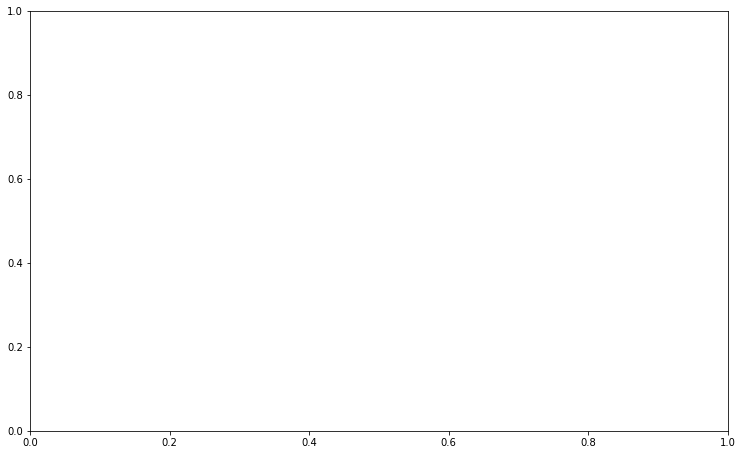

In [67]:
fig, ax = plt.subplots(figsize=(fig_width/1.2, fig_width/phi/1.2))
colors = [cmap(1-.9*i_color/N_model) for i_color in range(N_model)]
colors[0] = (0, 0, 0, 1)

for i, model_name in enumerate(models):
    ax = df_angle[(df_angle['model']==model_name)].plot(x="var", y="mean_prediction", color=colors[i],
                                                         marker='o', lw=1, label=model_names[model_name], ax=ax)
    print(f'Mean for {model_name}', np.mean(df_angle[(df_angle['model']==model_name)]['mean_prediction']))
    # print(f'Std for {model_name}', np.std(df_angle[(df_angle['model']==model_name)]['mean_prediction']))
ax = df_angle[(df_angle['model']=='vgg_lut')].plot(x="var", y="mean_prediction", color=colors[0],
                                                    marker='o', lw=1, ax=ax)


ax.hlines(xmin=-185, xmax=185, y=1/2, ls='--', ec='gray')#, label='chance level')
# ax.legend(loc='center right', fontsize=12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(-185, 185)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_ylabel('Mean Accuracies', font=font)
ax.set_xlabel('Rotation (°)', font=font)
plt.legend(bbox_to_anchor=(1.1, .5), loc='center', fontsize=fontsize, edgecolor='none')
plt.tight_layout();
plt.xticks(font=font)
plt.yticks(font=font)
if do_savefig: fig.savefig(os.path.join(figpath, 'full_rot_pruned.pdf'), **opts_savefig)

### Image processing and recognition for different labels with shuffled patches with prunned networks

In [68]:
#------------------------------------------------------------------------------------

class ShufflePatches(object): #https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
    def __init__(self, patch_size):
        self.ps = patch_size
    def __call__(self, x):
        # divide the batch of images into non-overlapping patches
        u = nnf.unfold(x.unsqueeze(dim=0), kernel_size=self.ps, stride=self.ps, padding=0)
        # permute the patches of each image in the batch
        pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
        # fold the permuted patches back together
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    return f.squeeze(dim=0)

def datasets_transforms_shuffle(paths=paths, image_size=args.image_size, p=0, shuffle=args.image_size , num_workers=0, angle=0, batch_size=args.batch_size, **kwargs):
    
    transforms_seq = transforms.Compose([
                        transforms.Resize((int(image_size), int(image_size))),
                        transforms.ToTensor(),    # Convert the image to pyTorch Tensor data type.
                        ShufflePatches((shuffle,shuffle))
                        transforms_norm ])   
    
    image_datasets = folder: datasets.ImageFolder(paths['animal']['test'], transform=transforms_seq)
    dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    dataset_sizes = len(image_datasets[task][folder])

    return dataset_sizes, dataloaders, image_datasets

(dataset_sizes, dataloaders, image_datasets) = datasets_transforms(paths=paths, image_size=args.image_size)

for task in args.tasks :
    pprint(f'Pre-selected tasks {task} : ')
    for folder in args.folders : print(f"Loaded {dataset_sizes[task][folder]} images under {folder}")
    
#------------------------------------------------------------------------------------

SyntaxError: invalid syntax (<ipython-input-68-4c9f61feb2a1>, line 21)

In [69]:
filename = f'{data_cache}/{datetag}_{HOST}_results_shuffle.json'
print(f'{filename=}')


shuffle_sizes = [256, 128, 64, 32]

if os.path.isfile(filename):
    df_shuffle = pd.read_json(filename)
else:
    df_shuffle = pd.DataFrame([], columns=['mean_prediction', 'model', 'var'])
    for shuffle_size in shuffle_sizes:
        print(shuffle_size)
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms_shuffle(
            image_size=args.image_size, shuffle=shuffle_size, batch_size=batch_size)
        for model_name in models_vgg.keys():
            model = models_vgg[model_name].to(device)
            acc_= 0
            for i_image, (data, label) in enumerate(dataloaders):
                data, label = data.to(device), label.to(device)
                with torch.no_grad():
                    outputs = model(data)
                    if model_name == 'vgg_lut':
                        percentage = torch.nn.functional.softmax(outputs, dim=1)
                        preds = torch.sum(percentage[:,match[task]], dim=1)
                        acc_ += torch.sum(torch.round(preds) == label.data)
                    else:
                        preds = torch.round(torch.sigmoid(outputs[:,0].data))
                        acc_ += torch.sum(preds == label.data)
            avg_acc = acc_ / dataset_sizes
            df_shuffle.loc[len(df_shuffle)] = {'model':model_name, 'mean_prediction':float(avg_acc), 'var':shuffle_size}  
            print(model_name, float(avg_acc), shuffle_size)
            torch.cuda.empty_cache()
        df_shuffle.to_json(filename)

filename='cached_data/2023-03-20_neo-ope-de04_results_shuffle.json'
256


NameError: name 'datasets_transforms_shuffle' is not defined

In [70]:
df_shuffle = pd.read_json(filename)
df_shuffle

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_shuffle.json does not exist

TypeError: no numeric data to plot

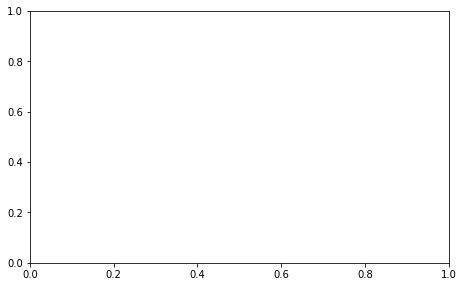

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width/2, fig_width/(phi*2)))

cmap = plt.cm.get_cmap('viridis')
all_models = ['VGG 16', 'VGG TLC','vgg-1', 'vgg-2','vgg-3','vgg-4', 'vgg-5','vgg-6','vgg-7','vgg-8','vgg-9','vgg-10', 'vgg-11', 'vgg-12']

color_dict = pd.Series({k:cmap(i/len(shuffle_sizes)) for i,k in enumerate(shuffle_sizes)})
all_ = ['temp_','temp_','temp_', 'temp_', 'temp', 'temp_']
cmap = plt.cm.get_cmap('inferno')
color_dict_s = pd.Series({k:cmap(i/len(all_)) for i,k in enumerate(all_)})
color_dict[64] = color_dict_s['temp']

for shuffle_size in shuffle_sizes:
    ax = df_shuffle[(df_shuffle['var']==shuffle_size)].plot(x="model", y="mean_prediction", color=color_dict[shuffle_size],
                                                         marker='o', label=f'{shuffle_size} x {shuffle_size}', ax=ax)
    fig.autofmt_xdate(rotation=45)
    ax.set_ylabel('Mean Accuracies', font=font)
    ax.hlines(xmin=-.5, xmax=len(all_models)-.5, y=1/2, ls='--', ec='gray')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

ax.set_xlabel('', font=font)
plt.legend(bbox_to_anchor=(1.12, .5), loc='center', fontsize=fontsize, edgecolor='none')
if do_savefig: fig.savefig(os.path.join(figpath, 'shuffle.pdf'), **opts_savefig);

## Dependence of accuracy scores between the two tasks

### Limiting our classification to Strictly animal / artifact

In [72]:
filename = f'{data_cache}/{datetag}_{HOST}_results_strictly_basic.json'
print(f'{filename=}')
paths['animal']['test'] = '../data/strictly_animal/test'
paths['artifact']['test'] = '../data/strictly_artifact/test'
if os.path.isfile(filename):
    df = pd.read_json(filename)
else:
    df = pd.DataFrame([], columns=['model', 'model_task', 'task', 'goal', 'likelihood', 'fps', 'time', 'i_image', 'filename', 'top_1', 'device_type']) 
        # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
    for task in args.tasks:
        pprint(task)
        for i_image, (data, label) in enumerate(dataloaders[task]['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg.keys():
                model = models_vgg[model_name].to(device)
                with torch.no_grad():
                    goal = 'target' if 'target' in image_datasets[task]['test'].imgs[i_image][0] else 'distractor'
                    tic = time.time()
                    out = model(data).squeeze(0).cpu()
                    model_task = 'animal' if 'animal' in model_name else 'artifact'
                    if model_name == 'vgg_lut':
                        model_task = 'Imagenet_challenge'
                        percentage = torch.nn.functional.softmax(out, dim=0)
                        likelihood = np.asarray(percentage[match[task]]).sum()
                    else:
                        likelihood = torch.sigmoid(out).numpy()[0]
                    elapsed_time = time.time() - tic
                    top_1 = 'target' if likelihood>0.50 else 'distractor'
                    elapsed_time = time.time() - tic
                df.loc[len(df)] = {'model':model_name,'model_task':model_task, 'task':task, 'top_1':top_1, 'goal':goal, 'likelihood':likelihood, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                        'i_image':i_image, 'filename':image_datasets[task]['test'].imgs[i_image][0], 'device_type':device.type}
                print(f'The {model_name} model categorize {model_task} with {likelihood:.3f} % likelihood ({top_1}) in {elapsed_time:.3f} seconds, groundtruth : {task}, {goal}')
    df.to_json(filename)

filename='cached_data/2023-03-20_neo-ope-de04_results_strictly_basic.json'


NameError: name 'datasets_transforms' is not defined

In [73]:
df_strictly = pd.read_json(filename)
df_strictly

FileNotFoundError: File cached_data/2023-03-20_neo-ope-de04_results_strictly_basic.json does not exist

In [74]:
df_acc_strictly = pd.DataFrame({model_name: {task: accuracy_score(df_strictly[(df_strictly['model']==model_name) & (df_strictly['task']==task)]["top_1"], 
                                                               df_strictly[(df_strictly['model']==model_name) & (df_strictly['task']==task)]["goal"])
                                    for task in args.tasks} 
                       for model_name in df_strictly['model'].unique()})

ax = df_acc_strictly.T.plot.bar(rot=20, figsize=(fig_width, fig_width//4), fontsize=20)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg)-.5, y=1/2, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f')
plt.legend(bbox_to_anchor=(1.2, .35), loc='lower right', fontsize=18)
ax.set_title(f'Animal vs Artifact images f1 score for re-trained models', size=22)
ax.set_ylabel('Accuracy', size=20)
ax.set_xlabel('Model', size=20);

NameError: name 'df_strictly' is not defined

In [75]:
df_acc = pd.DataFrame({model_name: {task: accuracy_score(df[(df['model']==model_name) & (df['task']==task)]["top_1"], 
                                                             df[(df['model']==model_name) & (df['task']==task)]["goal"])
                                    for task in args.tasks} 
                       for model_name in df['model'].unique()})

In [76]:
acc_dict = df_acc.to_dict()
acc_dict_s = df_acc_strictly.to_dict()
fig_width = 15
model_tested = [ 'Random', 'Animal', 'Artifact']
fig, axs = plt.subplots(1, 5, sharex=False, sharey=True, figsize=(fig_width, fig_width/5), gridspec_kw={'width_ratios': [2, 2, 2, 2, 1]})
cmap = plt.cm.get_cmap('viridis')
color_dict = pd.Series({k:cmap((i+.5)/len(model_tested)) for i, k in enumerate(model_tested)})

titles = ["(A) Animal set",  "(B) Strictly Animal set", "(C) Artifact set" , "(D) Strictly Artifact set", "(E) Random set" ]


F1_Random = .612 # HACK 
data_rand = { 'x_abs': ['Vgg Random'],
        'y_val' : [ F1_Random]} 
data_ani = { 'x_abs': ['Animal', 'Artifact'],
             'y_val' : [acc_dict['vgg16_tlc_animal']['animal'], acc_dict['vgg16_tlc_artifact']['animal']]}
data_art = { 'x_abs': ['Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict['vgg16_tlc_animal']['artifact'], acc_dict['vgg16_tlc_artifact']['artifact']]}
data_ani_s = { 'x_abs': ['Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict_s['vgg16_tlc_animal']['animal'], acc_dict_s['vgg16_tlc_artifact']['animal']]}
data_art_s = { 'x_abs': ['Vgg Animal', 'Vgg Artifact'],
             'y_val' : [acc_dict_s['vgg16_tlc_animal']['artifact'], acc_dict_s['vgg16_tlc_artifact']['artifact']]}

# HACK à simplifier!
df_rand = pd.DataFrame(data_rand)
df_ani = pd.DataFrame(data_ani)
df_art = pd.DataFrame(data_art)
df_ani_s = pd.DataFrame(data_ani_s)
df_art_s = pd.DataFrame(data_art_s)



axs[4].bar(df_rand['x_abs'], df_rand['y_val'],  align='center', color= color_dict[0])
axs[0].bar(df_ani['x_abs'], df_ani['y_val'], color= (color_dict[1], color_dict[2]))
axs[2].bar(df_art['x_abs'], df_art['y_val'], color= (color_dict[1], color_dict[2]))
axs[1].bar(df_ani_s['x_abs'], df_ani_s['y_val'], color= (color_dict[1], color_dict[2]))
axs[3].bar(df_art_s['x_abs'], df_art_s['y_val'], color= (color_dict[1], color_dict[2]))


axs[0].set_yticklabels(labels=[0, .25, .5, .75, 1], font=font)

axs[0].set_ylabel('Accuracy', fontsize = fontsize)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for j, ax in enumerate(axs):
    axs[j].hlines(xmin=-.5, xmax=1.5, y=1/2, ls='--', ec='gray') if j != 4 else axs[j].hlines(xmin=-.5, xmax=.5, y=1/2, ls='--', ec='gray')  
    axs[j].set_xticklabels(labels=['Animal','Artifact'], font=font) if j != 4 else axs[j].set_xticklabels(labels=['VGG Random'], font=font) 
    ax.set_title(titles[j], fontsize = 13)
    ax.tick_params(axis='both', labelsize=13)
    for i, container in enumerate(ax.containers):
        ax.bar_label(container, padding=-15, color='black', fontsize=fontsize, fmt='%.3f', rotation=0, label_type = 'edge', fontweight='bold')

    
plt.xticks(font=font)
plt.yticks(font=font)        
plt.tight_layout()
if do_savefig: fig.savefig(os.path.join(figpath, 'mean_accuracy.pdf'), **opts_savefig)

NameError: name 'df_acc_strictly' is not defined

#### Conclusion

We tested the networks Vgg TLC, Vgg Scale and Vgg Gray trained to detect an animal on the dataset where the targets are 'animal' (respectively train to detect an artifact on dataset where targets are artifacts). Then we tested the networks trained to detect an 'animal' on the dataset where the targets are 'artifact' and vice versa. Here, by exposing the predictions for the 'animal' and 'artifact' labels, we highlight a bias in the composition of the dataset. Although the outputs are independent, 'animal' images confidently correspond to 'non-artifact' images (and vice versa), thus facilitating the overall detection.

# BONUS: testing the model on images generated by stable diffusion

* [GitHub](https://github.com/CompVis/latent-diffusion).

```
@misc{rombach2021highresolution,
      title={High-Resolution Image Synthesis with Latent Diffusion Models}, 
      author={Robin Rombach and Andreas Blattmann and Dominik Lorenz and Patrick Esser and Björn Ommer},
      year={2021},
      eprint={2112.10752},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

```

Generated by
```
PYTORCH_ENABLE_MPS_FALLBACK=1 python scripts/txt2img.py --prompt "A very realistic object that does not exist in reality." --plms --n_samples=4 --n_rows=2 --n_iter=1 --seed 1998 --outdir="outputs/impossible-artifact"
```

with the following prompts :

* `animal-artifact` = "A very realistic animal that looks like an object." 
* `artifact-animal"` = "A very realistic object that looks like an animal." 
* `impossible-animal` = "A very realistic animal that does not exist in reality." 
* `impossible-artifact` = "A very realistic object that does not exist in reality." 
* `three-legged-animal` = "A very realistic animal that has three legs." 
